<a href="https://colab.research.google.com/github/jiuyuanx/94812-Application-of-NLP-and-LLM/blob/main/StockPrediction_withNLP/GameStop(GME)Forecasting_LSTM_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [337]:
# !pip yfinance -q
!pip install torchmetrics -q
!pip install torchsummaryX -q

In [338]:
import yfinance as yf
import seaborn as sns
import random
import numpy as np
import pandas as pd
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummaryX import summary
from tqdm.auto import tqdm
import os
import gc
from matplotlib import pyplot as plt
from pandas_datareader import data as pdr
import datetime
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
from torchmetrics.regression import MeanAbsolutePercentageError

cuda:0


In [339]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from scipy.stats import spearmanr as spearman
def get_metrics(prediction, true_labels):
  metrics = ['MSE', 'RMSE','MAE', 'MAPE', 'Serial Corr', 'Pearson Corr(IC),', 'Spearman Corr(IC)']
  metrics_value = [
  MSE(prediction,true_labels),
  MSE(prediction,true_labels)**0.5,
  MAE(prediction,true_labels),
  MAPE(prediction,true_labels),
  np.corrcoef(prediction,true_labels)[0,1],
  np.corrcoef(np.diff(prediction),np.diff(true_labels))[0,1],
  spearman(np.diff(prediction),np.diff(true_labels))[0],
  ]

  return pd.DataFrame([metrics_value], columns=metrics)


# **Load Reddit News & Create Dataset of Time Series News Combined**

In [340]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [341]:
df_reddit = pd.read_csv("/content/drive/MyDrive/94812/prediction/rGME_dataset_features.csv")[['date','title','score','num_comments']]
df_reddit

<ipython-input-341-a632c92e08de>:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_reddit = pd.read_csv("/content/drive/MyDrive/94812/prediction/rGME_dataset_features.csv")[['date','title','score','num_comments']]


date                                              title  score  \
0        2021-01-04              You NEED to see this about GME 🚀🚀🚀🚀🚀🚀    1.0   
1        2021-01-04                     Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀    1.0   
2        2021-01-05  THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...    1.0   
3        2021-01-05  You already know what we must do brothers and ...    1.0   
4        2021-01-06                          ICR conference (11th Jan)    1.0   
...             ...                                                ...    ...   
1033231  2021-12-31  Hedgies are relics of past generations- they h...    1.0   
1033232  2021-12-31                                    Snapchat on 🔥🔥🔥    1.0   
1033233  2021-12-31  MOASS has ruined me this year. But I will stil...    1.0   
1033234  2021-12-31                               Patterns for 2022???    1.0   
1033235  2021-12-31                                        When GWagon    1.0   

         num_comments  
0                 9.0  
1                 1.0  
2                 6.0  
3                 4.0  
4                10.0  
...               ...  
1033231           0.0  
1033232           0.0  
1033233           0.0  
1033234           0.0  
1033235           0.0  

[1033236 rows x 4 columns]

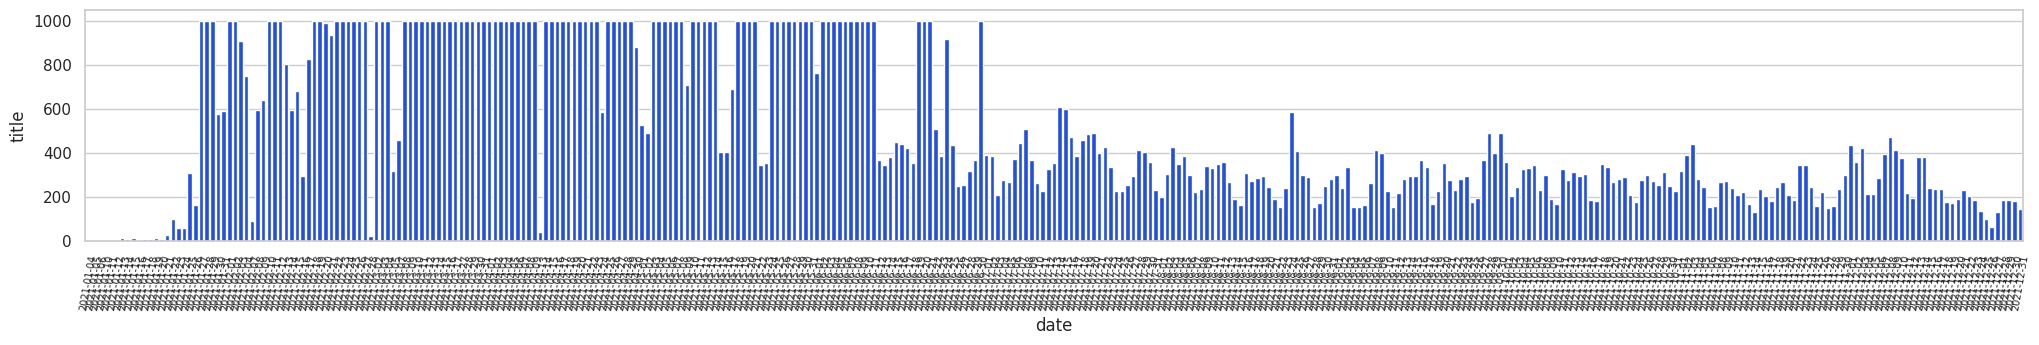

In [342]:
plt.figure(figsize=(25,3))
sns.set_style("whitegrid")
sns.set_palette("bright")
df_count = df_reddit.groupby('date').count().reset_index()
df_count['title']=df_count['title'].clip(0,1000)
sns.barplot(df_count, x='date', y='title')
plt.xticks(rotation=80, fontsize=7)
plt.show()

In [343]:
!pip install emoji -q
import emoji

def clean_text(text):
    import re
    text = emoji.demojize(text, delimiters=(" ", " "))  #emojis are important, keep them
    cleaned_text = re.sub(r'[^\w\s]', '', text)
    cleaned_text = cleaned_text.lower()
    return cleaned_text
df_reddit['title'] = df_reddit['title'].map(clean_text)
df_reddit

date                                              title  score  \
0        2021-01-04  you need to see this about gme  rocket  rocket...    1.0   
1        2021-01-04  short squeeze incoming  rocket  rocket  rocket...    1.0   
2        2021-01-05  this convinced me to all in  money_bag gme ext...    1.0   
3        2021-01-05  you already know what we must do brothers and ...    1.0   
4        2021-01-06                            icr conference 11th jan    1.0   
...             ...                                                ...    ...   
1033231  2021-12-31  hedgies are relics of past generations they ha...    1.0   
1033232  2021-12-31                     snapchat on  fire  fire  fire     1.0   
1033233  2021-12-31  moass has ruined me this year but i will still...    1.0   
1033234  2021-12-31                                  patterns for 2022    1.0   
1033235  2021-12-31                                        when gwagon    1.0   

         num_comments  
0                 9.0  
1                 1.0  
2                 6.0  
3                 4.0  
4                10.0  
...               ...  
1033231           0.0  
1033232           0.0  
1033233           0.0  
1033234           0.0  
1033235           0.0  

[1033236 rows x 4 columns]

## **Each day sample 300 news**

In [344]:
df_news = df_reddit.groupby('date').apply(lambda x: x.sample(min(len(x), 300))).reset_index(drop=True)
df_news

date                                              title  score  \
0      2021-01-04  you need to see this about gme  rocket  rocket...    1.0   
1      2021-01-04  short squeeze incoming  rocket  rocket  rocket...    1.0   
2      2021-01-05  this convinced me to all in  money_bag gme ext...    1.0   
3      2021-01-05  you already know what we must do brothers and ...    1.0   
4      2021-01-06                            icr conference 11th jan    1.0   
...           ...                                                ...    ...   
87686  2021-12-31                    thats a way to end the year lfg    1.0   
87687  2021-12-31  after months of hassle this europoor finally h...    2.0   
87688  2021-12-31  as promised here are the next 100 from ze dshe...    1.0   
87689  2021-12-31                     snapchat on  fire  fire  fire     1.0   
87690  2021-12-31  a sample of some of my shitty nfts ready to go...    1.0   

       num_comments  
0               9.0  
1               1.0  
2               6.0  
3               4.0  
4              10.0  
...             ...  
87686           0.0  
87687           0.0  
87688           0.0  
87689           0.0  
87690           0.0  

[87691 rows x 4 columns]

## **Load Time Series and Combine with News**

In [345]:
df = pd.read_csv('/content/drive/MyDrive/94812/prediction/s&p500_stocks.csv', index_col=[0], header=[0,1]).drop('Adj Close', level='Attribute', axis=1)
df.index = pd.to_datetime(df.index)
df = df.loc[:,('GME')].reset_index()
df

Attribute       Date     Open     High     Low    Close    Volume
0         2018-01-02   4.4900   4.5725   4.445   4.5650  11330800
1         2018-01-03   4.5725   4.5925   4.480   4.5500  15156800
2         2018-01-04   4.5500   4.5950   4.490   4.5800  11125200
3         2018-01-05   4.5950   4.6825   4.555   4.6700  12076000
4         2018-01-08   4.7000   4.8500   4.700   4.8075  14673600
...              ...      ...      ...     ...      ...       ...
1523      2024-01-23  15.0000  15.0200  14.050  14.1800   3495300
1524      2024-01-24  14.2800  14.3800  13.820  13.9500   2513800
1525      2024-01-25  13.9700  14.5400  13.920  14.5200   3635900
1526      2024-01-26  14.4400  14.7200  14.410  14.4900   2282300
1527      2024-01-29  14.5000  14.8100  14.320  14.7800   2164200

[1528 rows x 6 columns]

In [346]:
df_news['date'] = pd.to_datetime(df_news['date'])
df_gme_full=df_news.merge(df, how ='inner', left_on = 'date', right_on='Date').drop(columns=['date'])
df_gme_full

title  score  num_comments  \
0      you need to see this about gme  rocket  rocket...    1.0           9.0   
1      short squeeze incoming  rocket  rocket  rocket...    1.0           1.0   
2      this convinced me to all in  money_bag gme ext...    1.0           6.0   
3      you already know what we must do brothers and ...    1.0           4.0   
4                                icr conference 11th jan    1.0          10.0   
...                                                  ...    ...           ...   
65056                    thats a way to end the year lfg    1.0           0.0   
65057  after months of hassle this europoor finally h...    2.0           0.0   
65058  as promised here are the next 100 from ze dshe...    1.0           0.0   
65059                     snapchat on  fire  fire  fire     1.0           0.0   
65060  a sample of some of my shitty nfts ready to go...    1.0           0.0   

            Date       Open       High        Low    Close    Volume  
0     2021-01-04   4.750000   4.775000   4.287500   4.3125  40090000  
1     2021-01-04   4.750000   4.775000   4.287500   4.3125  40090000  
2     2021-01-05   4.337500   4.520000   4.307500   4.3425  19846000  
3     2021-01-05   4.337500   4.520000   4.307500   4.3425  19846000  
4     2021-01-06   4.335000   4.745000   4.332500   4.5900  24224800  
...          ...        ...        ...        ...      ...       ...  
65056 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000  
65057 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000  
65058 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000  
65059 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000  
65060 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000  

[65061 rows x 9 columns]

## **How many News each day vs Stock Price**

<ipython-input-347-43fc03da01ce>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=80)


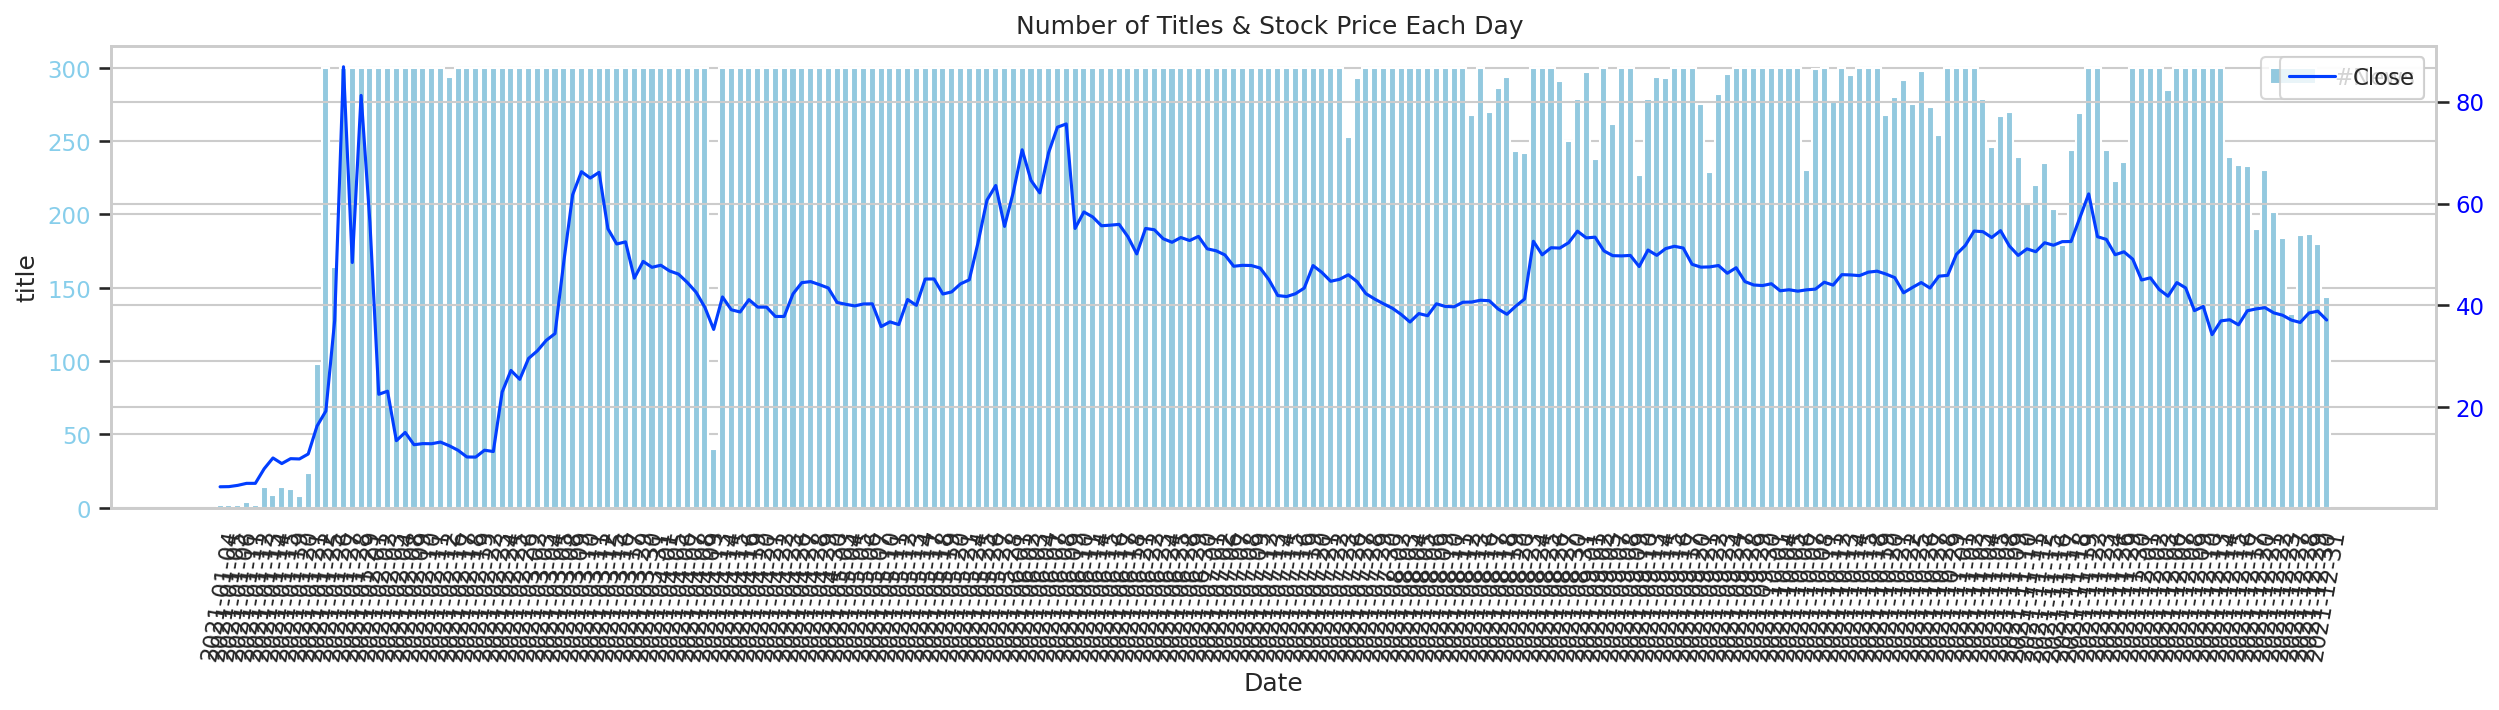

In [347]:
fig, ax1 = plt.subplots(figsize=(20, 4), dpi=150)
color = 'skyblue'
num_titles = df_gme_full[df_gme_full['Date']>pd.to_datetime('2020-11-30')][['Date','title']].groupby('Date').count().reset_index()
# num_titles['Date'] = num_titles['Date'].apply(lambda x: str(x))
sns.barplot(num_titles, x='Date', y='title',color=color, ax=ax1, label="#News")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=80)

ax2 = ax1.twinx()
color = 'blue'
price = df_gme_full[df_gme_full['Date']>pd.to_datetime('2020-11-30')][['Date','Close']].groupby('Date').mean().reset_index()
# price['Date'] = price['Date'].apply(lambda x: str(x))
sns.lineplot(price, color=color, ax=ax2)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Number of Titles & Stock Price Each Day ")
plt.show()

In [348]:
df_gme_full.to_csv("2021_ts_news.csv")

# **Load Time Series & News Combined**

In [349]:
# df = df_gme_full
df = pd.read_csv('/content/drive/MyDrive/94812/prediction/2021_ts_news.csv').drop(columns=['Unnamed: 0','score','num_comments']).dropna()
df

title        Date  \
0      short squeeze incoming  rocket  rocket  rocket...  2021-01-04   
1      you need to see this about gme  rocket  rocket...  2021-01-04   
2      this convinced me to all in  money_bag gme ext...  2021-01-05   
3      you already know what we must do brothers and ...  2021-01-05   
4      hey guys we have a free discord channel thats ...  2021-01-06   
...                                                  ...         ...   
65056  added another share of gme to make 2022 a very...  2021-12-31   
65057                                     tower of babel  2021-12-31   
65058             trip down memory lane i like the stock  2021-12-31   
65059  no i think gabe plotkin is one of the finest i...  2021-12-31   
65060         happy new year and a big f you to fidelity  2021-12-31   

            Open       High        Low    Close    Volume  
0       4.750000   4.775000   4.287500   4.3125  40090000  
1       4.750000   4.775000   4.287500   4.3125  40090000  
2       4.337500   4.520000   4.307500   4.3425  19846000  
3       4.337500   4.520000   4.307500   4.3425  19846000  
4       4.335000   4.745000   4.332500   4.5900  24224800  
...          ...        ...        ...      ...       ...  
65056  38.404999  39.182499  37.025002  37.0975   5576000  
65057  38.404999  39.182499  37.025002  37.0975   5576000  
65058  38.404999  39.182499  37.025002  37.0975   5576000  
65059  38.404999  39.182499  37.025002  37.0975   5576000  
65060  38.404999  39.182499  37.025002  37.0975   5576000  

[65025 rows x 7 columns]

# **Explore Bert Sentiment Analysis**

## **Inference sentiment with Bert fine-tuned**

In [350]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert = BertModel.from_pretrained("bert-base-uncased").to(device)

In [351]:
def tokenize(x):
  out = tokenizer.encode_plus(x,
        add_special_tokens=True,  # Add [CLS] and [SEP] tokens
        max_length=50,    # Truncate or pad to the maximum length
        truncation=True,          # Enable truncation if text is too long
        padding='max_length',     # Pad to the maximum length
        return_tensors='pt'       # Return PyTorch tensors)
  )

  return out
df_tokenized = df['title'].apply(lambda x: tokenize(x))
df_vec = df_tokenized.values
print("shape of one news:", df_vec[0]['input_ids'].shape)
df_vec[0]

shape of one news: torch.Size([1, 50])


{'input_ids': tensor([[  101,  2460, 11025, 14932,  7596,  7596,  7596,  7596,  7596,  7596,
          7596,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

In [352]:
class BERT(nn.Module):
    def __init__(self, bert):
        super(BERT, self).__init__()
        self.bert = bert
        self.mlp = nn.Sequential(
            nn.Linear(768,256),
            nn.LeakyReLU(),
            nn.Linear(256,256),
            nn.LeakyReLU(),
            nn.Linear(256,3)
        )

    def forward(self, x):
        input_ids= x[0].to(device)
        token_type= x[1].to(device)
        att_mask= x[2].to(device)
        out = self.bert(input_ids.to(device),  attention_mask=att_mask.to(device), token_type_ids=token_type.to(device))

        return self.mlp(out.pooler_output)

In [353]:
model = torch.load("/content/drive/MyDrive/94812/prediction/bert_finetuned.pt")
model((df_vec[0].input_ids.to(device), df_vec[0].token_type_ids.to(device), df_vec[0].attention_mask.to(device)))

tensor([[ 1.9833, -1.3301, -0.9498]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [354]:
gc.collect()
torch.cuda.empty_cache()

In [355]:
class NLPDataset(torch.utils.data.Dataset):
    def __init__(self, data) :
        super().__init__()
        self.data = data
        self.input_ids = torch.vstack([i['input_ids'].squeeze() for i in data])
        self.token_type_ids = torch.vstack([i['token_type_ids'].squeeze() for i in data])
        self.att_mask = torch.vstack([i['attention_mask'].squeeze() for i in data])
        # self.label = torch.LongTensor(label)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):

        return (self.input_ids[index], self.token_type_ids[index], self.att_mask[index])

In [356]:
inference_data = NLPDataset(df_vec)
inference_loader = torch.utils.data.DataLoader(
    dataset     = inference_data,
    batch_size  = 328,
    shuffle=False
)


In [357]:
# del X
gc.collect()
torch.cuda.empty_cache()

In [358]:
sentiments = []
for X in tqdm(inference_loader, "inferencing..."):

  res = model(X).cpu().detach().numpy()
  sentiments.append(res)
  del X
  gc.collect()
  torch.cuda.empty_cache()

df_sentiment = df.copy()
df_sentiment['sentiment'] = np.vstack(sentiments).argmax(1)
df_sentiment

inferencing...:   0%|          | 0/199 [00:00<?, ?it/s]

title        Date  \
0      short squeeze incoming  rocket  rocket  rocket...  2021-01-04   
1      you need to see this about gme  rocket  rocket...  2021-01-04   
2      this convinced me to all in  money_bag gme ext...  2021-01-05   
3      you already know what we must do brothers and ...  2021-01-05   
4      hey guys we have a free discord channel thats ...  2021-01-06   
...                                                  ...         ...   
65056  added another share of gme to make 2022 a very...  2021-12-31   
65057                                     tower of babel  2021-12-31   
65058             trip down memory lane i like the stock  2021-12-31   
65059  no i think gabe plotkin is one of the finest i...  2021-12-31   
65060         happy new year and a big f you to fidelity  2021-12-31   

            Open       High        Low    Close    Volume  sentiment  
0       4.750000   4.775000   4.287500   4.3125  40090000          0  
1       4.750000   4.775000   4.287500   4.3125  40090000          0  
2       4.337500   4.520000   4.307500   4.3425  19846000          0  
3       4.337500   4.520000   4.307500   4.3425  19846000          0  
4       4.335000   4.745000   4.332500   4.5900  24224800          0  
...          ...        ...        ...      ...       ...        ...  
65056  38.404999  39.182499  37.025002  37.0975   5576000          1  
65057  38.404999  39.182499  37.025002  37.0975   5576000          0  
65058  38.404999  39.182499  37.025002  37.0975   5576000          0  
65059  38.404999  39.182499  37.025002  37.0975   5576000          0  
65060  38.404999  39.182499  37.025002  37.0975   5576000          0  

[65025 rows x 8 columns]

In [359]:
df_sentiment[['sentiment','Close']].groupby('sentiment').count()

Close
sentiment       
0          49400
1           1497
2          14128

In [360]:
df_sentiment['sentiment'] = df_sentiment['sentiment'].apply(lambda x: -1 if x==2 else x)
df_sentiment

title        Date  \
0      short squeeze incoming  rocket  rocket  rocket...  2021-01-04   
1      you need to see this about gme  rocket  rocket...  2021-01-04   
2      this convinced me to all in  money_bag gme ext...  2021-01-05   
3      you already know what we must do brothers and ...  2021-01-05   
4      hey guys we have a free discord channel thats ...  2021-01-06   
...                                                  ...         ...   
65056  added another share of gme to make 2022 a very...  2021-12-31   
65057                                     tower of babel  2021-12-31   
65058             trip down memory lane i like the stock  2021-12-31   
65059  no i think gabe plotkin is one of the finest i...  2021-12-31   
65060         happy new year and a big f you to fidelity  2021-12-31   

            Open       High        Low    Close    Volume  sentiment  
0       4.750000   4.775000   4.287500   4.3125  40090000          0  
1       4.750000   4.775000   4.287500   4.3125  40090000          0  
2       4.337500   4.520000   4.307500   4.3425  19846000          0  
3       4.337500   4.520000   4.307500   4.3425  19846000          0  
4       4.335000   4.745000   4.332500   4.5900  24224800          0  
...          ...        ...        ...      ...       ...        ...  
65056  38.404999  39.182499  37.025002  37.0975   5576000          1  
65057  38.404999  39.182499  37.025002  37.0975   5576000          0  
65058  38.404999  39.182499  37.025002  37.0975   5576000          0  
65059  38.404999  39.182499  37.025002  37.0975   5576000          0  
65060  38.404999  39.182499  37.025002  37.0975   5576000          0  

[65025 rows x 8 columns]

In [361]:
dff = df_sentiment[df_sentiment.columns.difference(['title'])].groupby('Date').mean()
dff['price_change'] = dff['Close'].diff().fillna(0)
dff['sentiment_change'] = dff['sentiment'].diff().fillna(0)
dff

Close       High        Low       Open      Volume  sentiment  \
Date                                                                            
2021-01-04   4.312500   4.775000   4.287500   4.750000  40090000.0   0.000000   
2021-01-05   4.342500   4.520000   4.307500   4.337500  19846000.0   0.000000   
2021-01-06   4.590000   4.745000   4.332500   4.335000  24224800.0   0.000000   
2021-01-11   4.985000   5.162500   4.752500   4.852500  59632000.0  -0.250000   
2021-01-12   4.987500   5.100000   4.830000   4.990000  28242800.0  -0.500000   
...               ...        ...        ...        ...         ...        ...   
2021-12-27  37.077499  38.154999  35.000000  38.000000   6454400.0  -0.098485   
2021-12-28  36.615002  39.352501  36.602501  36.875000   5324400.0  -0.155914   
2021-12-29  38.482498  38.872501  35.535000  36.962502   8149600.0  -0.192513   
2021-12-30  38.832500  40.000000  37.500000  37.750000   6247600.0  -0.105556   
2021-12-31  37.097500  39.182499  37.025002  38.404999   5576000.0  -0.131944   

            price_change  sentiment_change  
Date                                        
2021-01-04      0.000000          0.000000  
2021-01-05      0.030000          0.000000  
2021-01-06      0.247500          0.000000  
2021-01-11      0.395000         -0.250000  
2021-01-12      0.002500         -0.250000  
...                  ...               ...  
2021-12-27     -0.957500         -0.049572  
2021-12-28     -0.462498         -0.057429  
2021-12-29      1.867496         -0.036599  
2021-12-30      0.350002          0.086958  
2021-12-31     -1.735001         -0.026389  

[240 rows x 8 columns]

## **Correlation between Sentiment & Price**

<Axes: xlabel='Date', ylabel='price_change'>

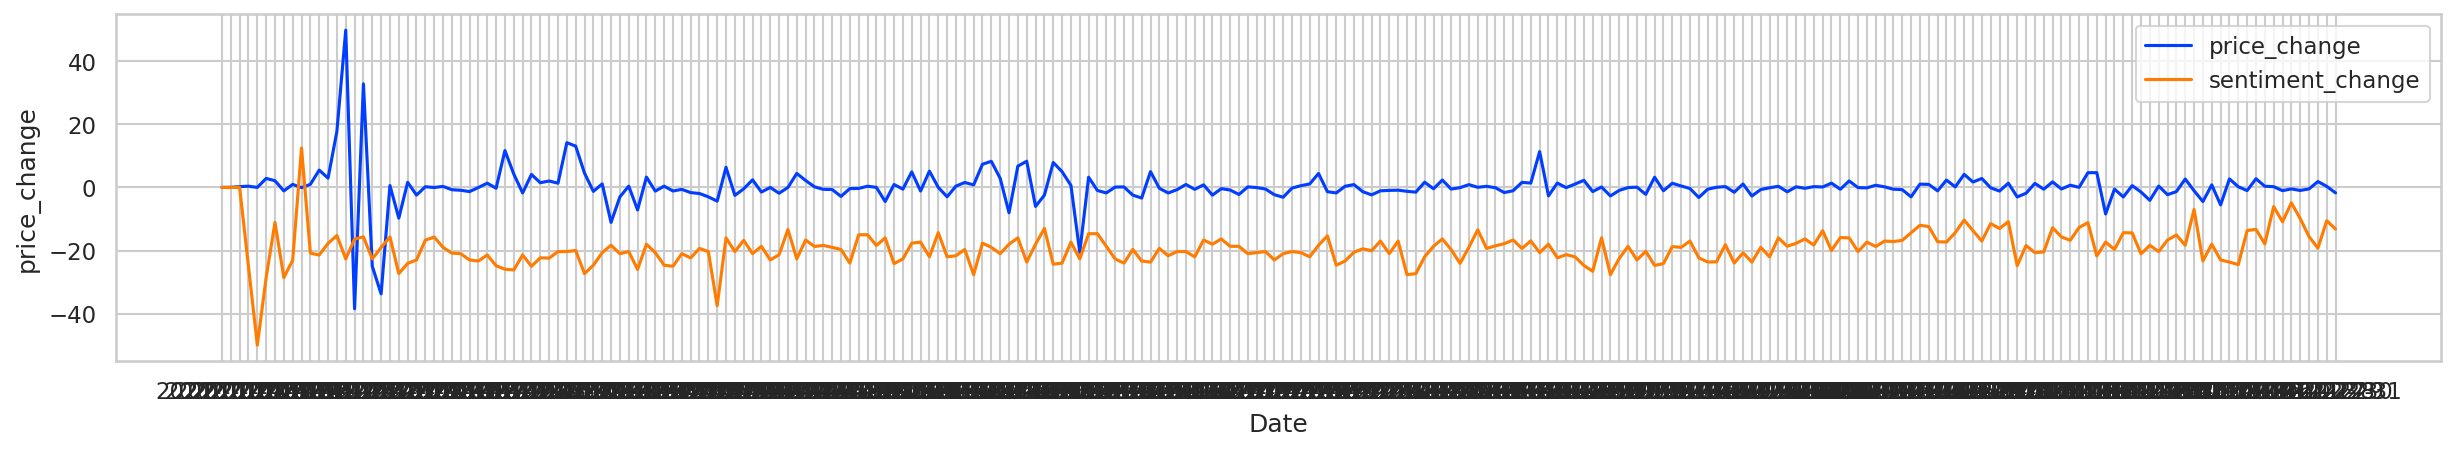

In [362]:
plt.figure(figsize=(20,3), dpi=150)
sns.lineplot(dff['price_change'], label ='price_change')
sns.lineplot(dff['sentiment']*100, label = 'sentiment_change')


<Axes: xlabel='Date', ylabel='price_change'>

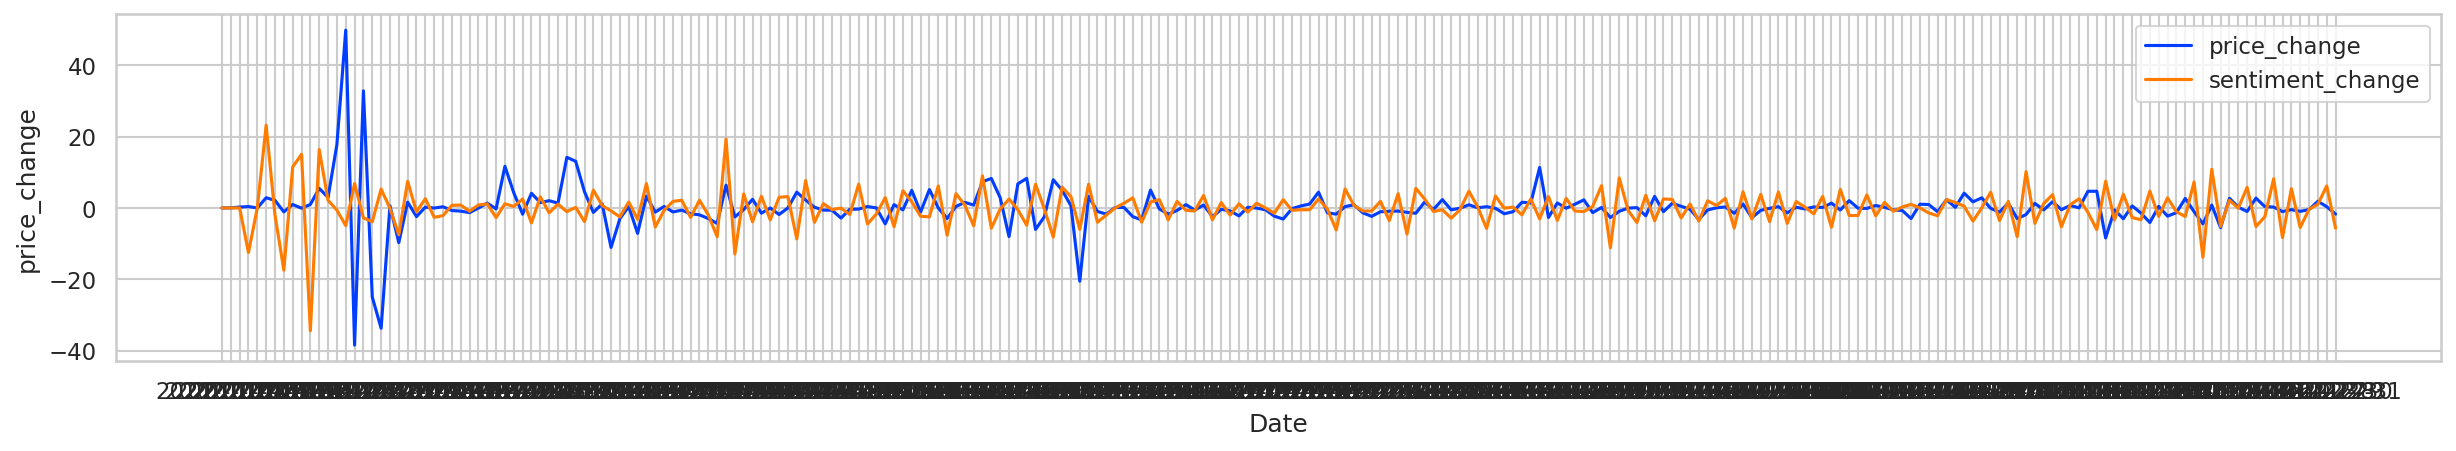

In [363]:
plt.figure(figsize=(20,3), dpi=150)
sns.lineplot(dff['price_change'], label ='price_change')
sns.lineplot(dff['sentiment_change'].diff().fillna(0)*50, label = 'sentiment_change')


<Axes: >

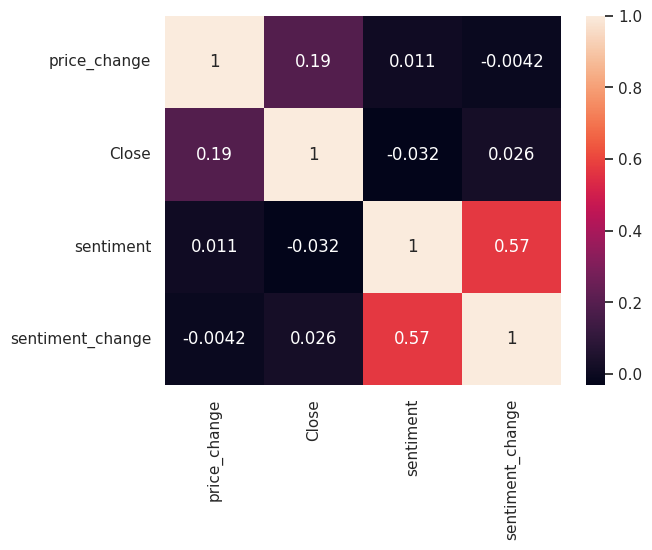

In [364]:
sns.heatmap(dff[['price_change','Close', 'sentiment','sentiment_change']].corr(),annot=True)

**The sentiment analysis our fine-tuned Bert gives does not give a good correlation with price or price change. Therefore we cannot use it to train LSTM. This can be due to several reasons: \
1.Our Bert is fine tuned on kaggle financial news headlines, which is drastically different from our Reddit post, and the model fails to generalize to Reddit post. \
2.Our model mostly outputs sentiment as neutral, if we could have included only positive and negative classes, or simply using the embeddings, it would give us stronger correlation with the stock price.\
But it serves as a good baseline methods, we'll train LSTM with sentiment labels first, and then explore Tf-idf embeddings, finally explore bert embeddings.**


# **Train with Baseline: with sentiment labels**

In [365]:
df_ts = dff[['Close', 'High', 'Low', 'Open', 'Volume','sentiment']]
df_ts['Date']= dff.index
df_ts['Date'] = pd.to_datetime(df_ts['Date'])
df_ts.index = df_ts['Date']
df_ts=df_ts.drop(columns=['Date'])

<ipython-input-365-0e534ff44ac9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts['Date']= dff.index
<ipython-input-365-0e534ff44ac9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts['Date'] = pd.to_datetime(df_ts['Date'])


### **Train Test Split**

In [366]:
total_len = len(df_ts)

train = df_ts[df_ts.index<pd.to_datetime("2021-05-01")]
val   = df_ts[(df_ts.index < pd.to_datetime("2021-06-01")) & (df_ts.index > pd.to_datetime("2021-05-01"))]
test  = df_ts[(df_ts.index < pd.to_datetime("2021-09-01")) & (df_ts.index > pd.to_datetime("2021-05-31"))]
print("train_len",len(train)/total_len,"val_len", len(val)/total_len,"test_len", len(test)/total_len)

train_len 0.2916666666666667 val_len 0.08333333333333333 test_len 0.2708333333333333


In [367]:
X_train = np.array(train.values)
X_val = np.array(val.values)
X_test = np.array(test.values)
factor_name = train.columns
print(factor_name)
X_train.shape, X_val.shape, X_test.shape


Index(['Close', 'High', 'Low', 'Open', 'Volume', 'sentiment'], dtype='object')


((70, 6), (20, 6), (65, 6))

In [368]:
train_mean = np.mean(X_train, axis=0, keepdims = True)
train_std = np.std(X_train, axis=0, keepdims = True)

### **Dataset & DataLoader**

In [369]:
class TSDataset(torch.utils.data.Dataset):
    def __init__(self, data, indices, seq_len, pred_len=20) :
        super().__init__()
        self.data = (data-torch.FloatTensor(train_mean))/torch.FloatTensor(train_std)
        self.indices = indices
        self.seq_len = seq_len
        self.pred_len= pred_len

    def __len__(self):
        return len(self.indices)

    def get_sequence(self, sequence, seq_len) :

        x = sequence[0:-self.pred_len,:]     #0~7 close open high low volume
        y = sequence[self.pred_len:,0]     #8 close

        return x, y

    def __getitem__(self, index):
        start, end = self.indices[index]
        sequence = self.data[start:end]
        x, y = self.get_sequence(sequence, self.seq_len)

        return x, y

def get_windows(data, window_size, step_size=1):
    # Start the first sub-sequence at index position 0
    start = 0
    end = window_size

    indices = []
    while end <= len(data)-1:      #proceed window by step size, count how many sequences
        indices.append((start, end))
        start += step_size
        end += step_size
    return indices

[(0, 6), (1, 7), (2, 8), (3, 9), (4, 10), (5, 11), (6, 12), (7, 13), (8, 14), (9, 15), (10, 16), (11, 17), (12, 18), (13, 19), (14, 20), (15, 21), (16, 22), (17, 23), (18, 24), (19, 25), (20, 26), (21, 27), (22, 28), (23, 29), (24, 30), (25, 31), (26, 32), (27, 33), (28, 34), (29, 35), (30, 36), (31, 37), (32, 38), (33, 39), (34, 40), (35, 41), (36, 42), (37, 43), (38, 44), (39, 45), (40, 46), (41, 47), (42, 48), (43, 49), (44, 50), (45, 51), (46, 52), (47, 53), (48, 54), (49, 55), (50, 56), (51, 57), (52, 58), (53, 59), (54, 60), (55, 61), (56, 62), (57, 63), (58, 64), (59, 65), (60, 66), (61, 67), (62, 68), (63, 69)]
torch.Size([64, 5]) torch.Size([64, 5, 6])
x:  tensor([-0.0676,  0.0357,  0.1039,  0.8220,  1.4849])
y_train:  tensor([0.0357, 0.1039, 0.8220, 1.4849, 1.7139])


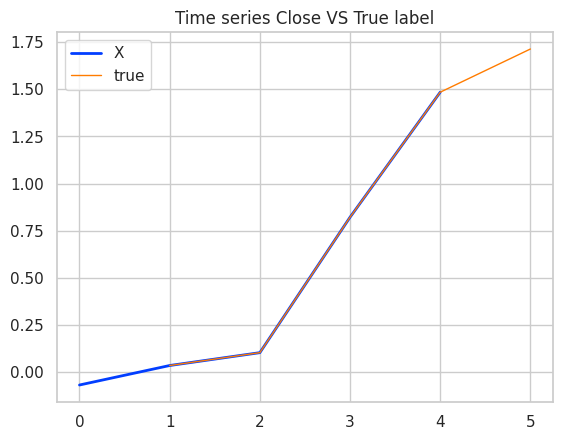

In [370]:
config = {
  'batch_size': 64,
  'lr':2e-3,
  'epochs': 30,
}
#TODO: tune context_len and pred_len
context_len=5
pred_len=1
window_len=context_len+pred_len
training_indices = get_windows(X_train, window_len, step_size=1) #TODO: Tune step size...
val_indices = get_windows(X_val,window_len, step_size=1) #TODO: Tune step size...
test_indices = get_windows(X_test, window_len, step_size=pred_len)

print(training_indices)
train_data=TSDataset(torch.FloatTensor(X_train), training_indices, window_len, pred_len=pred_len)
val_data=TSDataset(torch.FloatTensor(X_val), val_indices, window_len, pred_len=pred_len)
test_data=TSDataset(torch.FloatTensor(X_test), test_indices, window_len, pred_len=pred_len)

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config['batch_size'],
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = 24,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset     = test_data,
    batch_size  = 24,
    pin_memory  = False,
    shuffle=False
)

for batch in train_loader:
    x, y_train=batch
    print(y_train.shape, x.shape)
    print("x: ", x[0,:,0]) #0 is the closing price
    print("y_train: ", y_train[0,:])  #True label should shift by one to right
    plt.plot(x[0,:,0], linewidth=2, label ="X")
    plt.plot(np.arange(pred_len, window_len), y_train[0,:], linewidth=1, label ="true")
    plt.legend()
    plt.title("Time series Close VS True label")
    break

### **LSTM Model**

In [371]:
class LSTM_Block(nn.Module):
  def __init__(self, input_dim, output_dim, dropout=0.3):
    super(LSTM_Block, self).__init__()
    self.lstm = nn.LSTM(input_dim, output_dim, num_layers=1, dropout=dropout, bias=True, batch_first=True)
    # self.bn= nn.BatchNorm1d(output_dim)
    self.dp = nn.Dropout(dropout)
    # self.act = nn.LeakyReLU()
  def forward(self, x):
    out,_ = self.lstm(x)
    # out = self.bn(out.permute(0,2,1)).permute(0,2,1)
    out = self.dp(out)
    # out = self.act(out)
    return out

class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=512, dropout=0.3):
        super(LSTM, self).__init__()
        self.d_model=d_model
        self.model = torch.nn.Sequential(

            LSTM_Block(input_dim, d_model),
            LSTM_Block(d_model, d_model),
            nn.Linear(d_model,d_model),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model,output_dim)
        )


    def forward(self, x):
        return self.model(x)

In [372]:
#TODO: tune model parameters
model=LSTM(input_dim=X_train.shape[-1], output_dim=1, d_model=512, dropout=0.5).to(device)
# print(x.size)
for x, y in train_loader:
    x=torch.FloatTensor(x).to(device)
    y=torch.FloatTensor(y).to(device)
    print(x[0,:,0], y[0])
    print("x shape:",x.shape, "y shape:", y.shape)
    out=model(x)
    print("out shape:", out.shape)
    summary(model,x)
    break

tensor([-0.2631, -0.3515, -0.1435, -0.0676,  0.0357], device='cuda:0') tensor([-0.3515, -0.1435, -0.0676,  0.0357,  0.1039], device='cuda:0')
x shape: torch.Size([64, 5, 6]) y shape: torch.Size([64, 5])
out shape: torch.Size([64, 5, 1])
                     Kernel Shape  Output Shape     Params  Mult-Adds
Layer                                                                
0_model.0.LSTM_lstm             -  [64, 5, 512]   1.06496M  1.060864M
1_model.0.Dropout_dp            -  [64, 5, 512]          -          -
2_model.1.LSTM_lstm             -  [64, 5, 512]  2.101248M  2.097152M
3_model.1.Dropout_dp            -  [64, 5, 512]          -          -
4_model.Linear_2       [512, 512]  [64, 5, 512]   262.656k   262.144k
5_model.LeakyReLU_3             -  [64, 5, 512]          -          -
6_model.Dropout_4               -  [64, 5, 512]          -          -
7_model.Linear_5         [512, 1]    [64, 5, 1]      513.0      512.0
---------------------------------------------------------------

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


In [373]:
optimizer   = torch.optim.AdamW(model.parameters(), lr= config['lr'], weight_decay = 0.001)
criterion   = torch.nn.MSELoss()
scaler      = torch.cuda.amp.GradScaler()
scheduler   = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
# Optional (but Recommended): Create a custom class for a Teacher Force Schedule

In [374]:
def train():
      model.train() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(train_loader):
          optimizer.zero_grad()

          x, y_train = batch

          x = x.to(device)
          y_train = y_train.to(device)
          y_pred = model(x)

          loss = criterion(y_pred[:,-pred_len:], y_train.unsqueeze(-1)[:,-pred_len:])   #TODO: try changing 8 to others, if want the model to learn other columns
          loss.backward()
          optimizer.step()

          # train_plot.append(loss.item())
          running_loss += loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1)),
              lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
              # teacher_time="{:.04f}".format(teach/10)
               )
          batch_bar.update()

          del x, y_train, y_pred
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(train_loader)

def validate():
      model.eval() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(val_loader):
          optimizer.zero_grad()
          x, y_test = batch

          x = x.to(device)
          y_test = y_test.to(device)

          y_pred = model(x)
          val_loss = criterion(y_pred[:,-pred_len:], y_test.unsqueeze(-1)[:,-pred_len:])    #TODO: try changing 8 to others, if want the model to learn other columns

          running_loss += val_loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1))
               )
          batch_bar.update()

          del x, y_test
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(val_loader)

def test(test_loader):
        model.eval() # set to training mode
        model.to(device)
        batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
        prediction=[]
        true_labels = []
        for i, batch in enumerate(test_loader):
            optimizer.zero_grad()
            x, y_test = batch
            x = x.to(device)

            y_pred = model(x)[:,:,0] #take tomorrow
            prediction.append(y_pred[:,-pred_len:].cpu().detach().numpy())
            true_labels.append(y_test[:,-pred_len:].cpu().detach().numpy())

            del x, y_test
            torch.cuda.empty_cache()
            batch_bar.update()

        batch_bar.close()


        return np.concatenate(prediction)*train_std[0][0]+train_mean[0][0], \
               np.concatenate(true_labels)*train_std[0][0]+train_mean[0][0]

### **Train Loop**

In [375]:
# optimizer.param_groups[0]['lr']=1e-4
train_loss_plot=[]
val_loss_plot=[]
num_epochs=50
for epoch in range(0, num_epochs):

    # Call train and validate
    print("\nEpoch: {}/{}".format(epoch+1, num_epochs))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_loss              = train()
    train_loss_plot.append(train_loss)

    val_loss              = validate()
    val_loss_plot.append(val_loss)

    # trainer.teacher_forcing_ratio=max(trainer.teacher_forcing_ratio-0.05,0.1)
    scheduler.step()

    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}\t Validation Loss {:.04f}".format(train_loss, curr_lr, val_loss))



Epoch: 1/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.9485	 Learning Rate 0.0020000	 Validation Loss 0.5381

Epoch: 2/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.8543	 Learning Rate 0.0016000	 Validation Loss 0.4031

Epoch: 3/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.7197	 Learning Rate 0.0012800	 Validation Loss 0.2496

Epoch: 4/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.5839	 Learning Rate 0.0010240	 Validation Loss 0.1600

Epoch: 5/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.5612	 Learning Rate 0.0008192	 Validation Loss 0.1561

Epoch: 6/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.5144	 Learning Rate 0.0006554	 Validation Loss 0.1704

Epoch: 7/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4579	 Learning Rate 0.0005243	 Validation Loss 0.1854

Epoch: 8/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4303	 Learning Rate 0.0004194	 Validation Loss 0.1962

Epoch: 9/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4408	 Learning Rate 0.0003355	 Validation Loss 0.2033

Epoch: 10/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4248	 Learning Rate 0.0002684	 Validation Loss 0.2069

Epoch: 11/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4189	 Learning Rate 0.0002147	 Validation Loss 0.2086

Epoch: 12/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4054	 Learning Rate 0.0001718	 Validation Loss 0.2085

Epoch: 13/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4133	 Learning Rate 0.0001374	 Validation Loss 0.2078

Epoch: 14/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3758	 Learning Rate 0.0001100	 Validation Loss 0.2062

Epoch: 15/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3950	 Learning Rate 0.0000880	 Validation Loss 0.2043

Epoch: 16/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3912	 Learning Rate 0.0000704	 Validation Loss 0.2025

Epoch: 17/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3990	 Learning Rate 0.0000563	 Validation Loss 0.2009

Epoch: 18/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3899	 Learning Rate 0.0000450	 Validation Loss 0.1995

Epoch: 19/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3985	 Learning Rate 0.0000360	 Validation Loss 0.1984

Epoch: 20/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3468	 Learning Rate 0.0000288	 Validation Loss 0.1974

Epoch: 21/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3820	 Learning Rate 0.0000231	 Validation Loss 0.1966

Epoch: 22/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3944	 Learning Rate 0.0000184	 Validation Loss 0.1959

Epoch: 23/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3543	 Learning Rate 0.0000148	 Validation Loss 0.1954

Epoch: 24/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3676	 Learning Rate 0.0000118	 Validation Loss 0.1949

Epoch: 25/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3740	 Learning Rate 0.0000094	 Validation Loss 0.1945

Epoch: 26/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3825	 Learning Rate 0.0000076	 Validation Loss 0.1942

Epoch: 27/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3740	 Learning Rate 0.0000060	 Validation Loss 0.1940

Epoch: 28/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3747	 Learning Rate 0.0000048	 Validation Loss 0.1938

Epoch: 29/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3750	 Learning Rate 0.0000039	 Validation Loss 0.1936

Epoch: 30/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3611	 Learning Rate 0.0000031	 Validation Loss 0.1935

Epoch: 31/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3723	 Learning Rate 0.0000025	 Validation Loss 0.1934

Epoch: 32/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3783	 Learning Rate 0.0000020	 Validation Loss 0.1933

Epoch: 33/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3536	 Learning Rate 0.0000016	 Validation Loss 0.1932

Epoch: 34/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3431	 Learning Rate 0.0000013	 Validation Loss 0.1932

Epoch: 35/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3615	 Learning Rate 0.0000010	 Validation Loss 0.1931

Epoch: 36/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3704	 Learning Rate 0.0000008	 Validation Loss 0.1931

Epoch: 37/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3636	 Learning Rate 0.0000006	 Validation Loss 0.1930

Epoch: 38/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3648	 Learning Rate 0.0000005	 Validation Loss 0.1930

Epoch: 39/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3701	 Learning Rate 0.0000004	 Validation Loss 0.1930

Epoch: 40/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3743	 Learning Rate 0.0000003	 Validation Loss 0.1930

Epoch: 41/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3710	 Learning Rate 0.0000003	 Validation Loss 0.1930

Epoch: 42/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3736	 Learning Rate 0.0000002	 Validation Loss 0.1930

Epoch: 43/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3692	 Learning Rate 0.0000002	 Validation Loss 0.1930

Epoch: 44/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3780	 Learning Rate 0.0000001	 Validation Loss 0.1930

Epoch: 45/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3775	 Learning Rate 0.0000001	 Validation Loss 0.1930

Epoch: 46/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3803	 Learning Rate 0.0000001	 Validation Loss 0.1930

Epoch: 47/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3639	 Learning Rate 0.0000001	 Validation Loss 0.1930

Epoch: 48/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3755	 Learning Rate 0.0000001	 Validation Loss 0.1930

Epoch: 49/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3889	 Learning Rate 0.0000000	 Validation Loss 0.1929

Epoch: 50/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3712	 Learning Rate 0.0000000	 Validation Loss 0.1929


Text(0.5, 1.0, 'Validation loss')

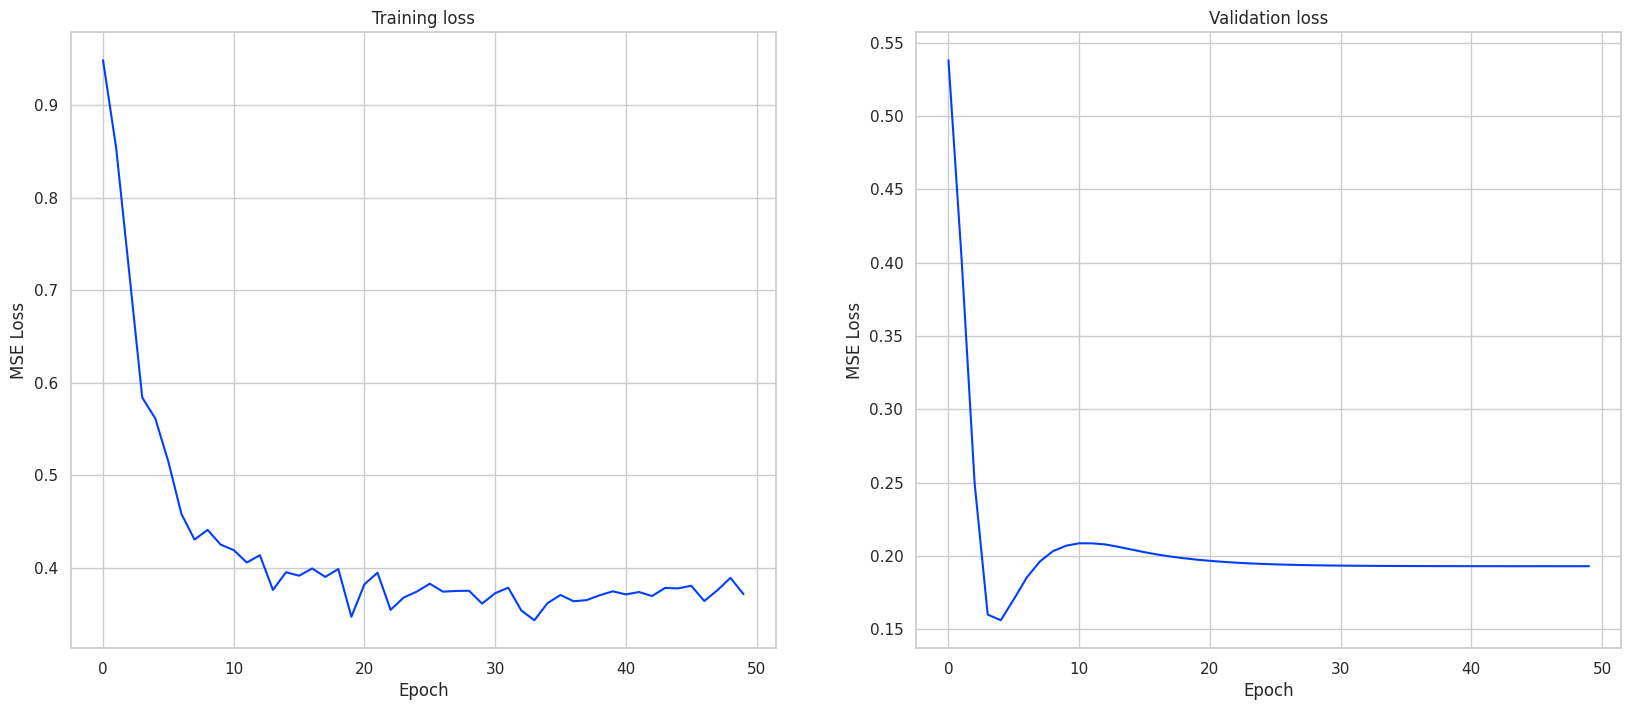

In [376]:
fig, ax=plt.subplots(1,2, figsize=(20,8))
# ax[0].plot(trainer.train_plot)
ax[0].plot(train_loss_plot)
ax[0].set_ylabel("MSE Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Training loss")

ax[1].plot(val_loss_plot)
ax[1].set_ylabel("MSE Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Validation loss")


### **Evaluate and Inference**

In [377]:
prediction,true_labels=test(test_loader)
prediction = prediction.reshape(-1)
true_labels = true_labels.reshape(-1)
print(prediction.shape, true_labels.shape)
baseline_test_metrics = get_metrics(prediction,true_labels)
baseline_test_metrics

Train:   0%|          | 0/3 [00:00<?, ?it/s]

(59,) (59,)


MSE      RMSE      MAE      MAPE  Serial Corr  Pearson Corr(IC),  \
0  74.499619  8.631316  6.19262  0.143273     0.869505          -0.202464   

   Spearman Corr(IC)  
0          -0.094837

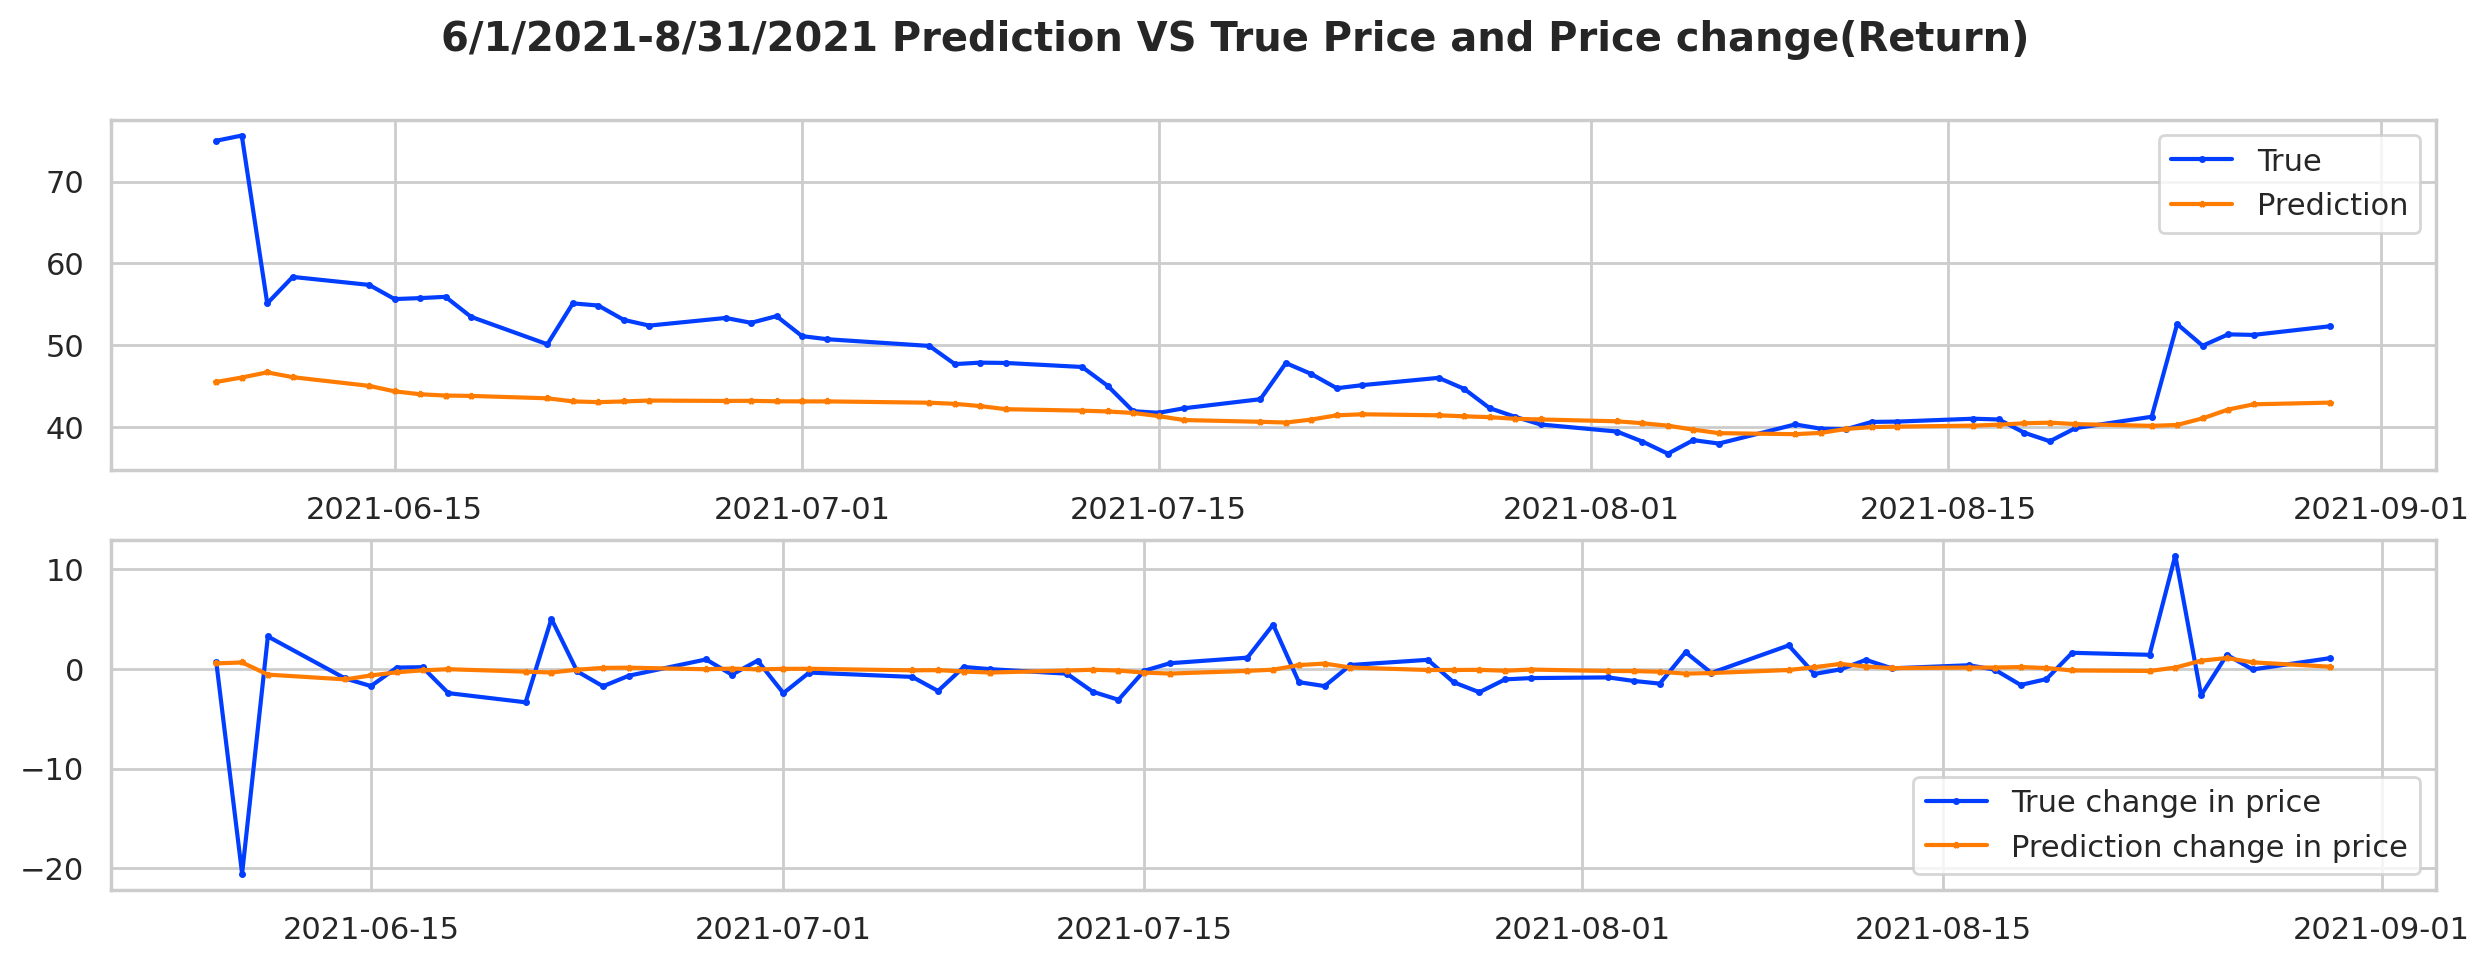

In [378]:
fig,ax=plt.subplots(2,1, figsize=(15,5),dpi=200)
date = df_ts[(df_ts.index>=pd.to_datetime("2021-06-08")) & (df_ts.index<=pd.to_datetime("2021-08-30"))].reset_index()['Date']
ax[0].plot(date, true_labels, label='True', marker='.', markersize=3)
ax[0].plot(date, prediction, label='Prediction',marker='*', markersize=2)
ax[0].legend()

ax[1].plot(date[1:], np.diff(true_labels), label='True change in price', marker='.', markersize=3)
ax[1].plot(date[1:],np.diff(prediction), label='Prediction change in price',marker='*', markersize=2)
ax[1].legend()
fig.suptitle("6/1/2021-8/31/2021 Prediction VS True Price and Price change(Return)", fontweight="bold")
plt.show()

In [379]:
inference_indices = get_windows(df_ts[df_ts.index<pd.to_datetime('2021-09-01')], window_len, step_size=pred_len)

inference_data=TSDataset(torch.FloatTensor(np.array(df_ts[df_ts.index<pd.to_datetime('2021-09-01')].values)), inference_indices, window_len, pred_len=pred_len)

inference_loader = torch.utils.data.DataLoader(
    dataset     = inference_data,
    batch_size  = len(inference_data),
    pin_memory  = False,
    shuffle=False
)
# inference_indices

In [380]:
prediction,true_labels=test(inference_loader)
# prediction = prediction[:,0]
# true_labels=true_labels[:,0]
prediction = prediction.reshape(-1)
true_labels = true_labels.reshape(-1)
print(prediction.shape, true_labels.shape)
baseline_train_test_metrics = get_metrics(prediction,true_labels)
baseline_train_test_metrics

Train:   0%|          | 0/1 [00:00<?, ?it/s]

(149,) (149,)


MSE       RMSE       MAE      MAPE  Serial Corr  Pearson Corr(IC),  \
0  113.71817  10.663872  7.287617  0.207108       0.7891           0.187938   

   Spearman Corr(IC)  
0           0.115053

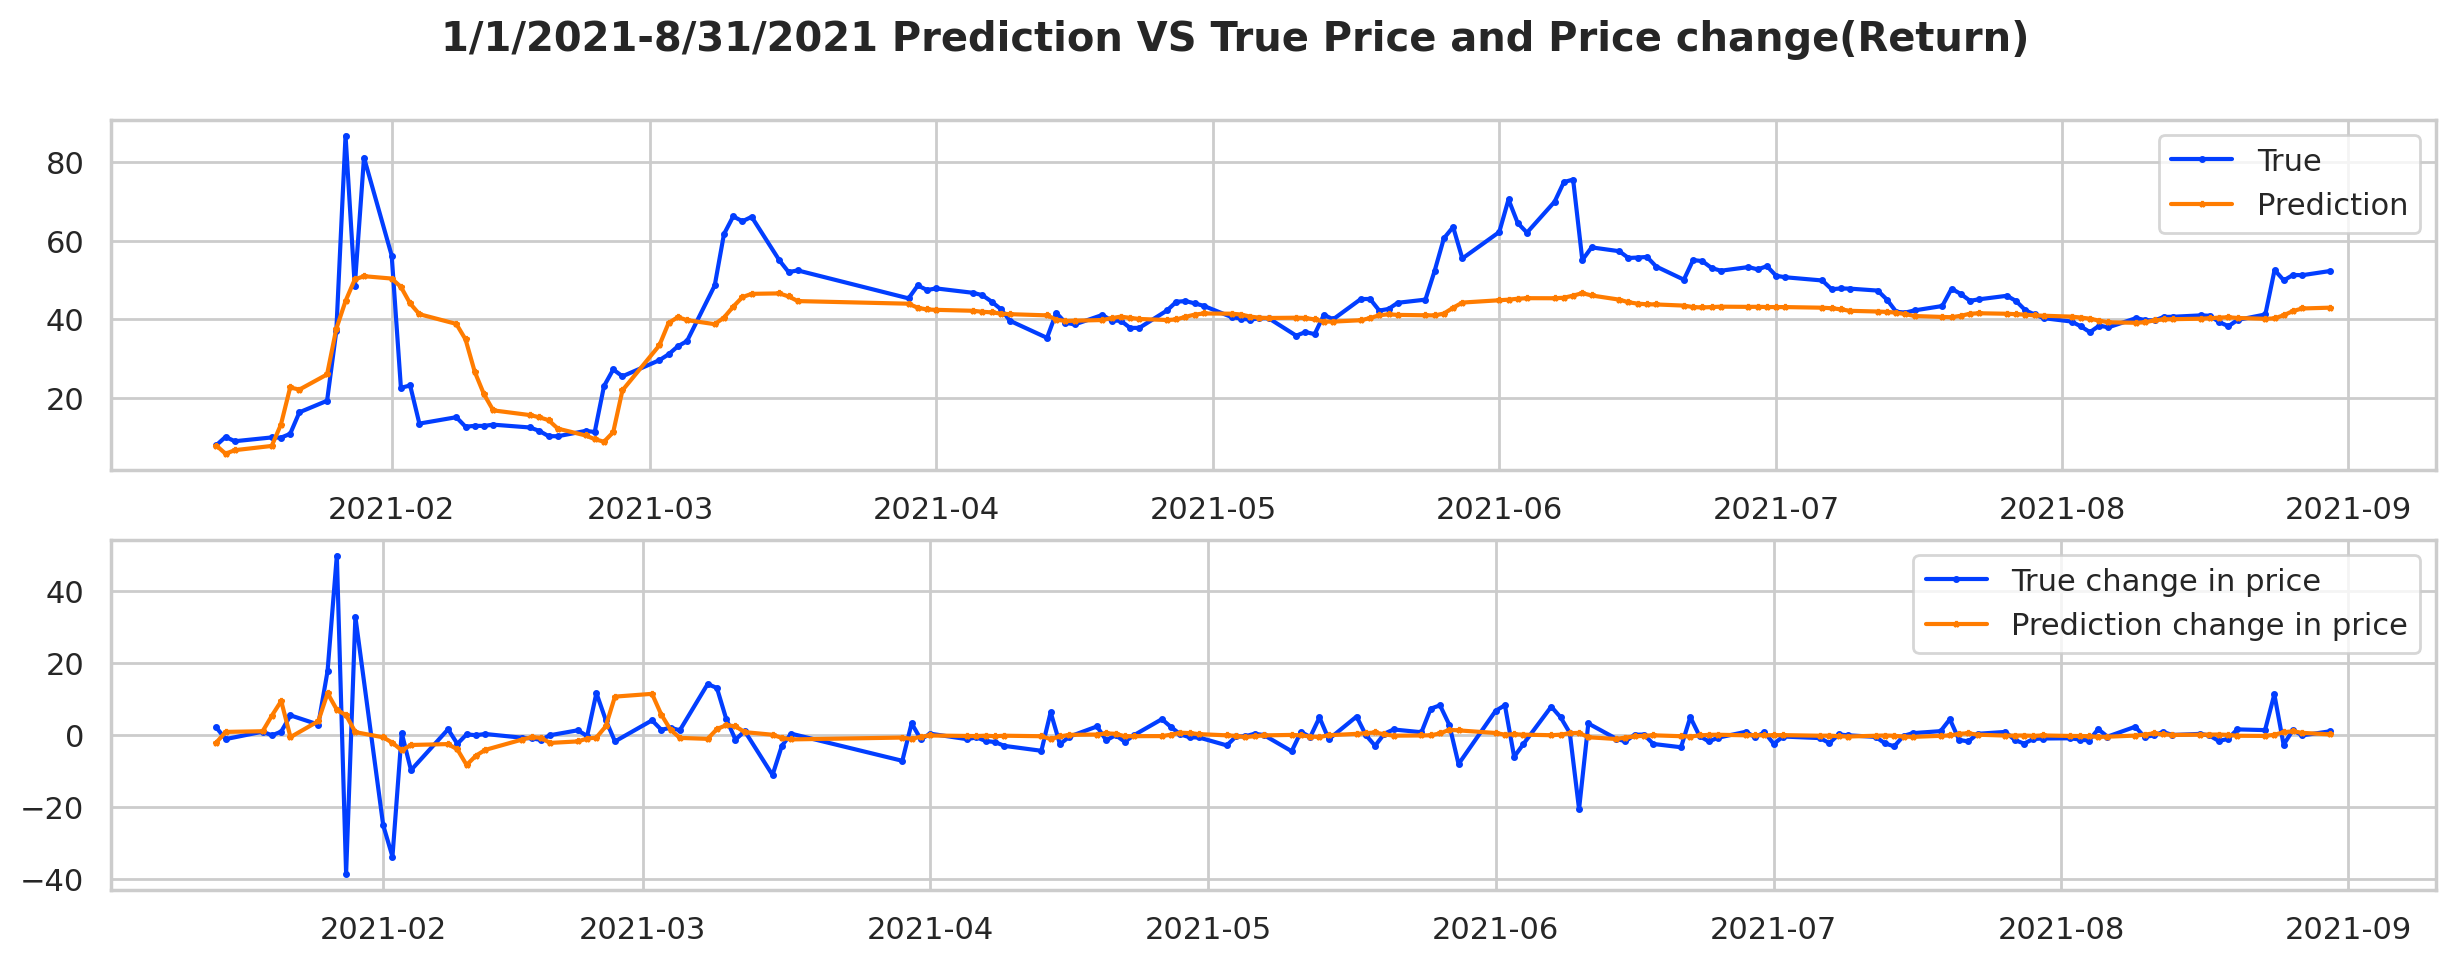

In [381]:
fig,ax=plt.subplots(2,1, figsize=(15,5),dpi=200)
date = df_ts[(df_ts.index>=pd.to_datetime("2021-01-13")) & (df_ts.index<=pd.to_datetime("2021-08-30"))].reset_index()['Date']
ax[0].plot(date,true_labels, label='True', marker='.', markersize=3)
ax[0].plot(date,prediction, label='Prediction',marker='*', markersize=2)
ax[0].legend()

ax[1].plot(date[1:],np.diff(true_labels), label='True change in price', marker='.', markersize=3)
ax[1].plot(date[1:], np.diff(prediction), label='Prediction change in price',marker='*', markersize=2)
ax[1].legend()
fig.suptitle("1/1/2021-8/31/2021 Prediction VS True Price and Price change(Return)", fontweight="bold")
plt.show()

# **Explore TF-IDF**

In [382]:
#combine Reddit titles each day to calculate TF-IDF, each day, we only take the first 10k words
df_comb_titles = df[['title','Date']].groupby('Date')['title'].apply('. '.join)
df_comb_titles  = pd.DataFrame(df_comb_titles)
df_comb_titles['title'] = df_comb_titles['title'].apply(lambda x:x[:10000])
df_comb_titles

title
Date                                                         
2021-01-04  short squeeze incoming  rocket  rocket  rocket...
2021-01-05  this convinced me to all in  money_bag gme ext...
2021-01-06  hey guys we have a free discord channel thats ...
2021-01-11  ryan cohen appointed to board. holly fck our g...
2021-01-12  low volume the day after cohen essentially tak...
...                                                       ...
2021-12-27  what is first song you will play after moass f...
2021-12-28  dont know what i was dragging my feet over the...
2021-12-29  next year be like. the narrative it changing t...
2021-12-30  today fudelity questioned why im drsing my sha...
2021-12-31  beep boop  germany . longest erection i have e...

[240 rows x 1 columns]

In [383]:
df_comb_titles['title'].apply(lambda x:len(x)).describe()

count      240.000000
mean      9492.133333
std       2084.785844
min        109.000000
25%      10000.000000
50%      10000.000000
75%      10000.000000
max      10000.000000
Name: title, dtype: float64

In [384]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(token_pattern=r'(?u)\b[A-Za-z]+\b')
tfidf_matrix = vectorizer.fit_transform(list(df_comb_titles['title']))
print("TF-IDF shape: ",tfidf_matrix.shape)

dense_matrix = tfidf_matrix.todense()
df_tfidf = pd.DataFrame(dense_matrix, columns=vectorizer.get_feature_names_out())
df_tfidf

TF-IDF shape:  (240, 19013)


a   aa  aaa  aaaaaaaahhhhhhhh  aaaaaaaand  aaaaaaaannnnddd  \
0    0.000000  0.0  0.0               0.0         0.0              0.0   
1    0.089885  0.0  0.0               0.0         0.0              0.0   
2    0.093839  0.0  0.0               0.0         0.0              0.0   
3    0.000000  0.0  0.0               0.0         0.0              0.0   
4    0.101130  0.0  0.0               0.0         0.0              0.0   
..        ...  ...  ...               ...         ...              ...   
235  0.146260  0.0  0.0               0.0         0.0              0.0   
236  0.139325  0.0  0.0               0.0         0.0              0.0   
237  0.121023  0.0  0.0               0.0         0.0              0.0   
238  0.129248  0.0  0.0               0.0         0.0              0.0   
239  0.167820  0.0  0.0               0.0         0.0              0.0   

     aaaaaand  aaaaand  aaaaannnnddd  aaaahhhh  ...  zoom  zoomed  zoomer  \
0         0.0      0.0           0.0       0.0  ...   0.0     0.0     0.0   
1         0.0      0.0           0.0       0.0  ...   0.0     0.0     0.0   
2         0.0      0.0           0.0       0.0  ...   0.0     0.0     0.0   
3         0.0      0.0           0.0       0.0  ...   0.0     0.0     0.0   
4         0.0      0.0           0.0       0.0  ...   0.0     0.0     0.0   
..        ...      ...           ...       ...  ...   ...     ...     ...   
235       0.0      0.0           0.0       0.0  ...   0.0     0.0     0.0   
236       0.0      0.0           0.0       0.0  ...   0.0     0.0     0.0   
237       0.0      0.0           0.0       0.0  ...   0.0     0.0     0.0   
238       0.0      0.0           0.0       0.0  ...   0.0     0.0     0.0   
239       0.0      0.0           0.0       0.0  ...   0.0     0.0     0.0   

     zooming  zooms  zoooooommmmm  zora   zu  zwebsites  zzz  
0        0.0    0.0           0.0   0.0  0.0        0.0  0.0  
1        0.0    0.0           0.0   0.0  0.0        0.0  0.0  
2        0.0    0.0           0.0   0.0  0.0        0.0  0.0  
3        0.0    0.0           0.0   0.0  0.0        0.0  0.0  
4        0.0    0.0           0.0   0.0  0.0        0.0  0.0  
..       ...    ...           ...   ...  ...        ...  ...  
235      0.0    0.0           0.0   0.0  0.0        0.0  0.0  
236      0.0    0.0           0.0   0.0  0.0        0.0  0.0  
237      0.0    0.0           0.0   0.0  0.0        0.0  0.0  
238      0.0    0.0           0.0   0.0  0.0        0.0  0.0  
239      0.0    0.0           0.0   0.0  0.0        0.0  0.0  

[240 rows x 19013 columns]

In [385]:
dff = df[df.columns.difference(['title'])].groupby('Date').mean()
dff['price_change'] = dff['Close'].diff().fillna(0)

## **PCA from 19k+dims to 200 dims**

In [386]:
from sklearn.decomposition import PCA
n_comp = 200
pca = PCA(n_components=n_comp)
pca_result = pca.fit_transform(np.array(dense_matrix))

explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance_ratio.sum())

# If you want to examine the PCA result as a DataFrame
df_pca = pd.DataFrame(pca_result,columns=['pc'+str(i) for i in range(n_comp)])
df_pca.index = dff.index
df_pca

Explained variance ratio: 0.9118628421300292


pc0       pc1       pc2       pc3       pc4       pc5  \
Date                                                                     
2021-01-04  0.695287  0.362973  0.520816 -0.260858  0.037049 -0.120516   
2021-01-05  0.229971  0.524581 -0.249454 -0.044766 -0.411172  0.223191   
2021-01-06  0.300863  0.615266 -0.291001 -0.024507 -0.165793  0.118730   
2021-01-11  0.395093  0.560940 -0.061559 -0.201401  0.312365  0.033664   
2021-01-12  0.175520  0.479171 -0.282984 -0.034525  0.620624  0.130090   
...              ...       ...       ...       ...       ...       ...   
2021-12-27 -0.090014  0.035943  0.082995 -0.072393  0.064857  0.024066   
2021-12-28 -0.139229  0.000105  0.039900 -0.001746  0.094017  0.062174   
2021-12-29 -0.202626  0.028954 -0.036752  0.044086  0.049562  0.071253   
2021-12-30 -0.094665  0.051895  0.001352 -0.054872 -0.010991  0.025795   
2021-12-31 -0.101873  0.005954 -0.050255  0.002958  0.064045  0.076473   

                 pc6       pc7       pc8       pc9  ...     pc190     pc191  \
Date                                                ...                       
2021-01-04  0.033733  0.029710  0.015855  0.029252  ...  0.013069 -0.008147   
2021-01-05 -0.126080  0.093782 -0.222677  0.490353  ...  0.000364 -0.003393   
2021-01-06 -0.230324  0.520830  0.598464 -0.143057  ... -0.000007  0.000451   
2021-01-11 -0.174621  0.110701 -0.412627  0.079267  ...  0.004223  0.000910   
2021-01-12 -0.136119 -0.032341 -0.033587 -0.061429  ... -0.000720  0.001443   
...              ...       ...       ...       ...  ...       ...       ...   
2021-12-27  0.100757  0.018497 -0.042188 -0.039908  ... -0.043149 -0.019590   
2021-12-28  0.074990  0.015481  0.000724 -0.002421  ... -0.061427 -0.039750   
2021-12-29  0.036320  0.015346 -0.016440  0.001776  ...  0.053604 -0.032814   
2021-12-30  0.059367  0.041703 -0.038467  0.011719  ...  0.008129  0.014679   
2021-12-31  0.110408  0.020758  0.008179 -0.036396  ... -0.040006  0.016218   

               pc192     pc193     pc194     pc195     pc196     pc197  \
Date                                                                     
2021-01-04  0.001687  0.009575 -0.005258  0.015584  0.017826 -0.007016   
2021-01-05 -0.000246 -0.001490  0.000315 -0.007134 -0.001327 -0.003377   
2021-01-06 -0.001483  0.002789 -0.002739  0.000101 -0.006063  0.001531   
2021-01-11 -0.004867  0.004082  0.000599 -0.007741  0.007723  0.009403   
2021-01-12  0.006138  0.000234 -0.000360  0.000941 -0.018398 -0.004027   
...              ...       ...       ...       ...       ...       ...   
2021-12-27  0.039600  0.069287 -0.000376 -0.002226 -0.026876 -0.018963   
2021-12-28 -0.001473 -0.017699 -0.039498  0.073316  0.046542  0.049815   
2021-12-29  0.011462  0.025820 -0.004286 -0.048767  0.061250 -0.066807   
2021-12-30 -0.005650  0.021211 -0.002636 -0.034374 -0.008697 -0.020380   
2021-12-31  0.014100 -0.025199  0.015341  0.008335 -0.014812  0.009754   

               pc198     pc199  
Date                            
2021-01-04 -0.025731  0.001786  
2021-01-05 -0.008940 -0.009101  
2021-01-06  0.003756  0.006685  
2021-01-11  0.000168  0.005184  
2021-01-12  0.012771  0.003920  
...              ...       ...  
2021-12-27  0.021549 -0.002755  
2021-12-28 -0.018871  0.017817  
2021-12-29  0.010153  0.015918  
2021-12-30 -0.022720  0.008634  
2021-12-31  0.001420  0.020259  

[240 rows x 200 columns]

In [387]:
df_full = pd.concat([dff,df_pca],axis=1)
df_full

Close       High        Low       Open      Volume  \
Date                                                                 
2021-01-04   4.312500   4.775000   4.287500   4.750000  40090000.0   
2021-01-05   4.342500   4.520000   4.307500   4.337500  19846000.0   
2021-01-06   4.590000   4.745000   4.332500   4.335000  24224800.0   
2021-01-11   4.985000   5.162500   4.752500   4.852500  59632000.0   
2021-01-12   4.987500   5.100000   4.830000   4.990000  28242800.0   
...               ...        ...        ...        ...         ...   
2021-12-27  37.077499  38.154999  35.000000  38.000000   6454400.0   
2021-12-28  36.615002  39.352501  36.602501  36.875000   5324400.0   
2021-12-29  38.482498  38.872501  35.535000  36.962502   8149600.0   
2021-12-30  38.832500  40.000000  37.500000  37.750000   6247600.0   
2021-12-31  37.097500  39.182499  37.025002  38.404999   5576000.0   

            price_change       pc0       pc1       pc2       pc3  ...  \
Date                                                              ...   
2021-01-04      0.000000  0.695287  0.362973  0.520816 -0.260858  ...   
2021-01-05      0.030000  0.229971  0.524581 -0.249454 -0.044766  ...   
2021-01-06      0.247500  0.300863  0.615266 -0.291001 -0.024507  ...   
2021-01-11      0.395000  0.395093  0.560940 -0.061559 -0.201401  ...   
2021-01-12      0.002500  0.175520  0.479171 -0.282984 -0.034525  ...   
...                  ...       ...       ...       ...       ...  ...   
2021-12-27     -0.957500 -0.090014  0.035943  0.082995 -0.072393  ...   
2021-12-28     -0.462498 -0.139229  0.000105  0.039900 -0.001746  ...   
2021-12-29      1.867496 -0.202626  0.028954 -0.036752  0.044086  ...   
2021-12-30      0.350002 -0.094665  0.051895  0.001352 -0.054872  ...   
2021-12-31     -1.735001 -0.101873  0.005954 -0.050255  0.002958  ...   

               pc190     pc191     pc192     pc193     pc194     pc195  \
Date                                                                     
2021-01-04  0.013069 -0.008147  0.001687  0.009575 -0.005258  0.015584   
2021-01-05  0.000364 -0.003393 -0.000246 -0.001490  0.000315 -0.007134   
2021-01-06 -0.000007  0.000451 -0.001483  0.002789 -0.002739  0.000101   
2021-01-11  0.004223  0.000910 -0.004867  0.004082  0.000599 -0.007741   
2021-01-12 -0.000720  0.001443  0.006138  0.000234 -0.000360  0.000941   
...              ...       ...       ...       ...       ...       ...   
2021-12-27 -0.043149 -0.019590  0.039600  0.069287 -0.000376 -0.002226   
2021-12-28 -0.061427 -0.039750 -0.001473 -0.017699 -0.039498  0.073316   
2021-12-29  0.053604 -0.032814  0.011462  0.025820 -0.004286 -0.048767   
2021-12-30  0.008129  0.014679 -0.005650  0.021211 -0.002636 -0.034374   
2021-12-31 -0.040006  0.016218  0.014100 -0.025199  0.015341  0.008335   

               pc196     pc197     pc198     pc199  
Date                                                
2021-01-04  0.017826 -0.007016 -0.025731  0.001786  
2021-01-05 -0.001327 -0.003377 -0.008940 -0.009101  
2021-01-06 -0.006063  0.001531  0.003756  0.006685  
2021-01-11  0.007723  0.009403  0.000168  0.005184  
2021-01-12 -0.018398 -0.004027  0.012771  0.003920  
...              ...       ...       ...       ...  
2021-12-27 -0.026876 -0.018963  0.021549 -0.002755  
2021-12-28  0.046542  0.049815 -0.018871  0.017817  
2021-12-29  0.061250 -0.066807  0.010153  0.015918  
2021-12-30 -0.008697 -0.020380 -0.022720  0.008634  
2021-12-31 -0.014812  0.009754  0.001420  0.020259  

[240 rows x 206 columns]

## **Correlation between TF-IDF(PCA) & Price**

<Axes: >

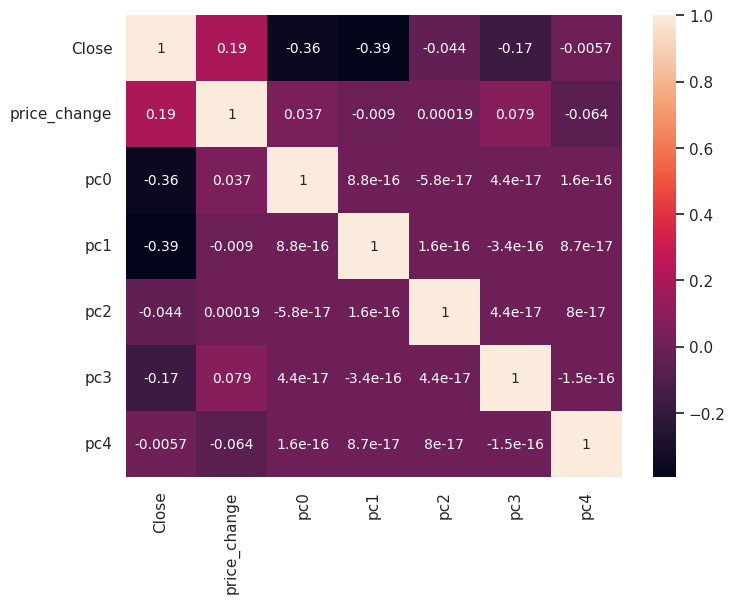

In [388]:
plt.figure(figsize=(8,6),dpi=100)
sns.heatmap(df_full[['Close','price_change','pc0','pc1','pc2','pc3','pc4']].corr(),annot=True,annot_kws={"size":10})

Text(0.5, 1.0, 'GameStop(GME) stock price VS Principal Component')

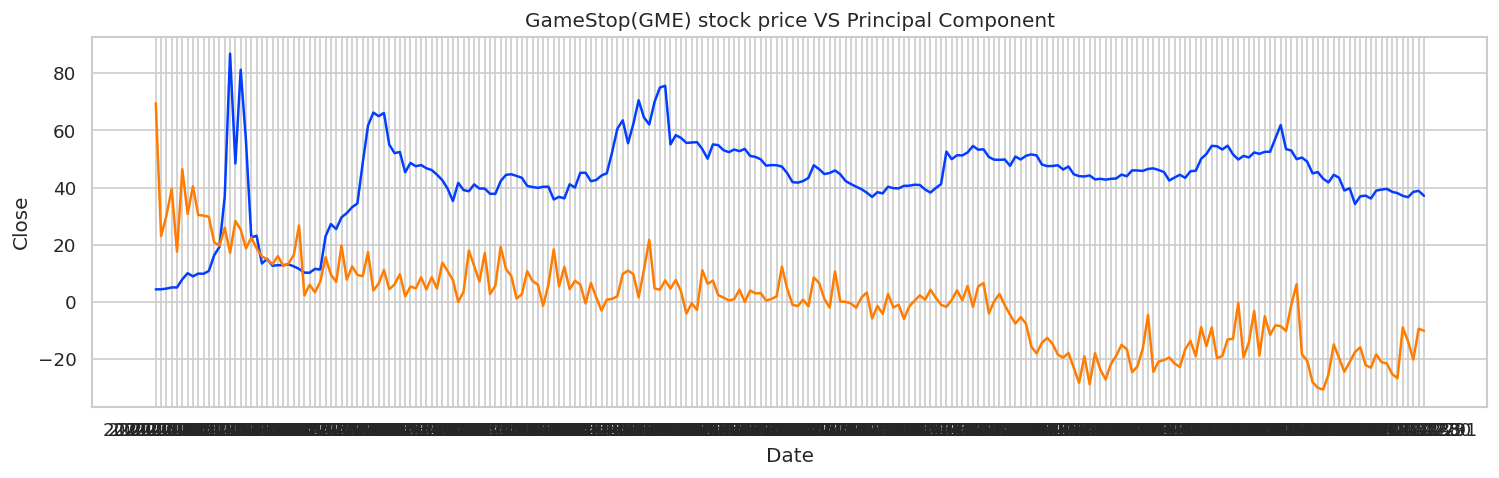

In [389]:
plt.figure(figsize=(15,4),dpi=120)
sns.set(style="whitegrid", palette="bright")
sns.lineplot(df_full['Close'])
sns.lineplot(df_full['pc0']*100)
plt.title("GameStop(GME) stock price VS Principal Component")

## **Time Series with TF-IDF features**

In [390]:
df_ts=df_full.copy().reset_index()
df_ts['Date'] = pd.to_datetime(df_ts['Date'])
df_ts.index = df_ts['Date']
df_ts=df_ts[df_ts.columns.difference(['Date','score','price_change','num_comments','sentiment'])]
df_ts #dimension should be 5(open, high, low, close, volume) +200 =205

Close       High        Low       Open      Volume       pc0  \
Date                                                                           
2021-01-04   4.312500   4.775000   4.287500   4.750000  40090000.0  0.695287   
2021-01-05   4.342500   4.520000   4.307500   4.337500  19846000.0  0.229971   
2021-01-06   4.590000   4.745000   4.332500   4.335000  24224800.0  0.300863   
2021-01-11   4.985000   5.162500   4.752500   4.852500  59632000.0  0.395093   
2021-01-12   4.987500   5.100000   4.830000   4.990000  28242800.0  0.175520   
...               ...        ...        ...        ...         ...       ...   
2021-12-27  37.077499  38.154999  35.000000  38.000000   6454400.0 -0.090014   
2021-12-28  36.615002  39.352501  36.602501  36.875000   5324400.0 -0.139229   
2021-12-29  38.482498  38.872501  35.535000  36.962502   8149600.0 -0.202626   
2021-12-30  38.832500  40.000000  37.500000  37.750000   6247600.0 -0.094665   
2021-12-31  37.097500  39.182499  37.025002  38.404999   5576000.0 -0.101873   

                 pc1      pc10     pc100     pc101  ...      pc90      pc91  \
Date                                                ...                       
2021-01-04  0.362973 -0.024268 -0.027545 -0.004008  ...  0.011593 -0.000708   
2021-01-05  0.524581  0.062226 -0.015280 -0.000213  ... -0.013336 -0.012316   
2021-01-06  0.615266 -0.053298 -0.003213 -0.005775  ...  0.005225 -0.016016   
2021-01-11  0.560940  0.326207 -0.017596  0.000735  ... -0.011394  0.017308   
2021-01-12  0.479171  0.004277  0.015565 -0.001651  ... -0.000996  0.009035   
...              ...       ...       ...       ...  ...       ...       ...   
2021-12-27  0.035943  0.045828 -0.050543 -0.056362  ... -0.078115 -0.014498   
2021-12-28  0.000105 -0.006680  0.049800 -0.052488  ... -0.016667  0.047033   
2021-12-29  0.028954 -0.020386  0.067260 -0.036203  ...  0.019001  0.004787   
2021-12-30  0.051895 -0.016069 -0.067419  0.000578  ...  0.012635  0.031017   
2021-12-31  0.005954  0.020857  0.061414  0.026203  ... -0.059461 -0.039079   

                pc92      pc93      pc94      pc95      pc96      pc97  \
Date                                                                     
2021-01-04  0.022934 -0.001124 -0.004999  0.018278 -0.007917  0.047057   
2021-01-05 -0.007527 -0.006031 -0.010788  0.003059  0.008277 -0.000242   
2021-01-06  0.005824 -0.008534  0.003443  0.001435  0.007597  0.001896   
2021-01-11  0.003302 -0.008551 -0.009506  0.008389 -0.001045 -0.011617   
2021-01-12 -0.021894 -0.018377  0.004964  0.005411 -0.002175  0.018019   
...              ...       ...       ...       ...       ...       ...   
2021-12-27 -0.017927  0.018800 -0.040544 -0.016003  0.106241 -0.029824   
2021-12-28  0.013115 -0.020080 -0.013133  0.004361  0.024050 -0.028213   
2021-12-29 -0.019644  0.016593 -0.056374 -0.027565  0.013615 -0.005058   
2021-12-30 -0.049431 -0.029543 -0.029024  0.025136 -0.094364  0.003203   
2021-12-31  0.063977  0.080600  0.018447 -0.028440  0.010817  0.079514   

                pc98      pc99  
Date                            
2021-01-04  0.004913 -0.017195  
2021-01-05 -0.004673  0.028834  
2021-01-06 -0.003313  0.013218  
2021-01-11  0.004549  0.003499  
2021-01-12  0.007823  0.014524  
...              ...       ...  
2021-12-27  0.012399 -0.012599  
2021-12-28  0.021831  0.030279  
2021-12-29  0.075444 -0.074140  
2021-12-30 -0.020185  0.064955  
2021-12-31 -0.041980 -0.002761  

[240 rows x 205 columns]

# **Training with Tf-idf**

### **Train Test Split**

In [391]:
total_len = len(df_ts)

train = df_ts[df_ts.index<pd.to_datetime("2021-05-01")]
val   = df_ts[(df_ts.index < pd.to_datetime("2021-06-01")) & (df_ts.index > pd.to_datetime("2021-05-01"))]
test  = df_ts[(df_ts.index < pd.to_datetime("2021-09-01")) & (df_ts.index > pd.to_datetime("2021-05-31"))]
print("train_len",len(train)/total_len,"val_len", len(val)/total_len,"test_len", len(test)/total_len)

train_len 0.2916666666666667 val_len 0.08333333333333333 test_len 0.2708333333333333


In [392]:
X_train = np.array(train.values)
X_val = np.array(val.values)
X_test = np.array(test.values)
factor_name = train.columns
print(factor_name)
X_train.shape, X_val.shape, X_test.shape


Index(['Close', 'High', 'Low', 'Open', 'Volume', 'pc0', 'pc1', 'pc10', 'pc100',
       'pc101',
       ...
       'pc90', 'pc91', 'pc92', 'pc93', 'pc94', 'pc95', 'pc96', 'pc97', 'pc98',
       'pc99'],
      dtype='object', length=205)


((70, 205), (20, 205), (65, 205))

In [393]:
train_mean = np.mean(X_train, axis=0, keepdims = True)
train_std = np.std(X_train, axis=0, keepdims = True)

### **Dataset & DataLoader**

In [394]:
class TSDataset(torch.utils.data.Dataset):
    def __init__(self, data, indices, seq_len, pred_len=20) :
        super().__init__()
        self.data = (data-torch.FloatTensor(train_mean))/torch.FloatTensor(train_std)
        self.indices = indices
        self.seq_len = seq_len
        self.pred_len= pred_len

    def __len__(self):
        return len(self.indices)

    def get_sequence(self, sequence, seq_len) :

        x = sequence[0:-self.pred_len,:]     #0~7 close open high low volume
        y = sequence[self.pred_len:,0]     #8 close

        return x, y

    def __getitem__(self, index):
        start, end = self.indices[index]
        sequence = self.data[start:end]
        x, y = self.get_sequence(sequence, self.seq_len)

        return x, y

def get_windows(data, window_size, step_size=1):
    # Start the first sub-sequence at index position 0
    start = 0
    end = window_size

    indices = []
    while end <= len(data)-1:      #proceed window by step size, count how many sequences
        indices.append((start, end))
        start += step_size
        end += step_size
    return indices

[(0, 6), (1, 7), (2, 8), (3, 9), (4, 10), (5, 11), (6, 12), (7, 13), (8, 14), (9, 15), (10, 16), (11, 17), (12, 18), (13, 19), (14, 20), (15, 21), (16, 22), (17, 23), (18, 24), (19, 25), (20, 26), (21, 27), (22, 28), (23, 29), (24, 30), (25, 31), (26, 32), (27, 33), (28, 34), (29, 35), (30, 36), (31, 37), (32, 38), (33, 39), (34, 40), (35, 41), (36, 42), (37, 43), (38, 44), (39, 45), (40, 46), (41, 47), (42, 48), (43, 49), (44, 50), (45, 51), (46, 52), (47, 53), (48, 54), (49, 55), (50, 56), (51, 57), (52, 58), (53, 59), (54, 60), (55, 61), (56, 62), (57, 63), (58, 64), (59, 65), (60, 66), (61, 67), (62, 68), (63, 69)]
torch.Size([64, 5]) torch.Size([64, 5, 205])
x:  tensor([1.7075, 1.1463, 0.9949, 1.0157, 0.6550])
y_train:  tensor([1.1463, 0.9949, 1.0157, 0.6550, 0.8215])


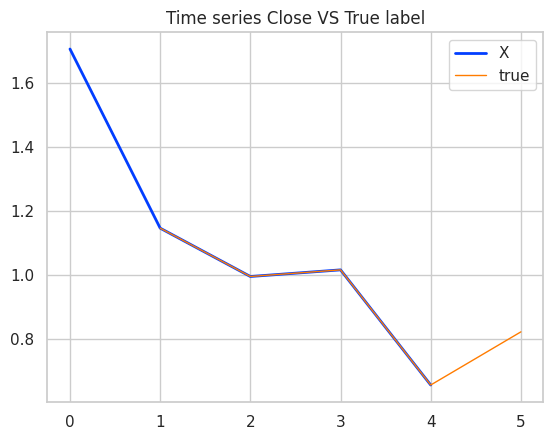

In [395]:
config = {
  'batch_size': 64,
  'lr':2e-3,
  'epochs': 30,
}
#TODO: tune context_len and pred_len
context_len=5
pred_len=1
window_len=context_len+pred_len
training_indices = get_windows(X_train, window_len, step_size=1) #TODO: Tune step size...
val_indices = get_windows(X_val,window_len, step_size=1) #TODO: Tune step size...
test_indices = get_windows(X_test, window_len, step_size=pred_len)

print(training_indices)
train_data=TSDataset(torch.FloatTensor(X_train), training_indices, window_len, pred_len=pred_len)
val_data=TSDataset(torch.FloatTensor(X_val), val_indices, window_len, pred_len=pred_len)
test_data=TSDataset(torch.FloatTensor(X_test), test_indices, window_len, pred_len=pred_len)

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config['batch_size'],
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = 24,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset     = test_data,
    batch_size  = 24,
    pin_memory  = False,
    shuffle=False
)

for batch in train_loader:
    x, y_train=batch
    print(y_train.shape, x.shape)
    print("x: ", x[0,:,0]) #0 is the closing price
    print("y_train: ", y_train[0,:])  #True label should shift by one to right
    plt.plot(x[0,:,0], linewidth=2, label ="X")
    plt.plot(np.arange(pred_len, window_len), y_train[0,:], linewidth=1, label ="true")
    plt.legend()
    plt.title("Time series Close VS True label")
    break

### **LSTM Model**

In [396]:
class LSTM_Block(nn.Module):
  def __init__(self, input_dim, output_dim, dropout=0.3):
    super(LSTM_Block, self).__init__()
    self.lstm = nn.LSTM(input_dim, output_dim, num_layers=1, dropout=dropout, bias=True, batch_first=True)
    # self.bn= nn.BatchNorm1d(output_dim)
    self.dp = nn.Dropout(dropout)
    # self.act = nn.LeakyReLU()
  def forward(self, x):
    out,_ = self.lstm(x)
    # out = self.bn(out.permute(0,2,1)).permute(0,2,1)
    out = self.dp(out)
    # out = self.act(out)
    return out

class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=512, dropout=0.3):
        super(LSTM, self).__init__()
        self.d_model=d_model
        self.model = torch.nn.Sequential(

            LSTM_Block(input_dim, d_model),
            LSTM_Block(d_model, d_model),
            nn.Linear(d_model,d_model),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model,output_dim)
        )


    def forward(self, x):
        return self.model(x)


In [397]:
#TODO: tune model parameters
model=LSTM(input_dim=X_train.shape[-1], output_dim=1, d_model=512, dropout=0.5).to(device)
# print(x.size)
for x, y in train_loader:
    x=torch.FloatTensor(x).to(device)
    y=torch.FloatTensor(y).to(device)
    print(x[0,:,0], y[0])
    print("x shape:",x.shape, "y shape:", y.shape)
    out=model(x)
    print("out shape:", out.shape)
    summary(model,x)
    break

tensor([0.8220, 1.4849, 1.7139, 1.6506, 1.7075], device='cuda:0') tensor([1.4849, 1.7139, 1.6506, 1.7075, 1.1463], device='cuda:0')
x shape: torch.Size([64, 5, 205]) y shape: torch.Size([64, 5])
out shape: torch.Size([64, 5, 1])
                     Kernel Shape  Output Shape     Params  Mult-Adds
Layer                                                                
0_model.0.LSTM_lstm             -  [64, 5, 512]  1.472512M  1.468416M
1_model.0.Dropout_dp            -  [64, 5, 512]          -          -
2_model.1.LSTM_lstm             -  [64, 5, 512]  2.101248M  2.097152M
3_model.1.Dropout_dp            -  [64, 5, 512]          -          -
4_model.Linear_2       [512, 512]  [64, 5, 512]   262.656k   262.144k
5_model.LeakyReLU_3             -  [64, 5, 512]          -          -
6_model.Dropout_4               -  [64, 5, 512]          -          -
7_model.Linear_5         [512, 1]    [64, 5, 1]      513.0      512.0
---------------------------------------------------------------------
 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


In [398]:
optimizer   = torch.optim.AdamW(model.parameters(), lr= config['lr'], weight_decay = 1e-3)
criterion   = torch.nn.MSELoss()
scaler      = torch.cuda.amp.GradScaler()
scheduler   = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
# Optional (but Recommended): Create a custom class for a Teacher Force Schedule

In [399]:
def train():
      model.train() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(train_loader):
          optimizer.zero_grad()

          x, y_train = batch

          x = x.to(device)
          y_train = y_train.to(device)
          y_pred = model(x)

          loss = criterion(y_pred[:,-pred_len:], y_train.unsqueeze(-1)[:,-pred_len:])   #TODO: try changing 8 to others, if want the model to learn other columns
          loss.backward()
          optimizer.step()

          # train_plot.append(loss.item())
          running_loss += loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1)),
              lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
              # teacher_time="{:.04f}".format(teach/10)
               )
          batch_bar.update()

          del x, y_train, y_pred
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(train_loader)

def validate():
      model.eval() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(val_loader):
          optimizer.zero_grad()
          x, y_test = batch

          x = x.to(device)
          y_test = y_test.to(device)

          y_pred = model(x)
          val_loss = criterion(y_pred[:,-pred_len:], y_test.unsqueeze(-1)[:,-pred_len:])    #TODO: try changing 8 to others, if want the model to learn other columns

          running_loss += val_loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1))
               )
          batch_bar.update()

          del x, y_test
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(val_loader)

def test(test_loader):
        model.eval() # set to training mode
        model.to(device)
        batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
        prediction=[]
        true_labels = []
        for i, batch in enumerate(test_loader):
            optimizer.zero_grad()
            x, y_test = batch
            x = x.to(device)

            y_pred = model(x)[:,:,0] #take tomorrow
            prediction.append(y_pred[:,-pred_len:].cpu().detach().numpy())
            true_labels.append(y_test[:,-pred_len:].cpu().detach().numpy())

            del x, y_test
            torch.cuda.empty_cache()
            batch_bar.update()

        batch_bar.close()


        return np.concatenate(prediction)*train_std[0][0]+train_mean[0][0], \
               np.concatenate(true_labels)*train_std[0][0]+train_mean[0][0]

### **Train Loop**

In [400]:
# optimizer.param_groups[0]['lr']=1e-4
train_loss_plot=[]
val_loss_plot=[]
num_epochs=50
for epoch in range(0, num_epochs):

    # Call train and validate
    print("\nEpoch: {}/{}".format(epoch+1, num_epochs))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_loss              = train()
    train_loss_plot.append(train_loss)

    val_loss              = validate()
    val_loss_plot.append(val_loss)

    # trainer.teacher_forcing_ratio=max(trainer.teacher_forcing_ratio-0.05,0.1)
    scheduler.step()

    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}\t Validation Loss {:.04f}".format(train_loss, curr_lr, val_loss))



Epoch: 1/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.9357	 Learning Rate 0.0020000	 Validation Loss 0.5144

Epoch: 2/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.7950	 Learning Rate 0.0016000	 Validation Loss 0.4553

Epoch: 3/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4832	 Learning Rate 0.0012800	 Validation Loss 0.4048

Epoch: 4/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1869	 Learning Rate 0.0010240	 Validation Loss 0.4903

Epoch: 5/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2746	 Learning Rate 0.0008192	 Validation Loss 0.5485

Epoch: 6/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1426	 Learning Rate 0.0006554	 Validation Loss 0.5739

Epoch: 7/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0895	 Learning Rate 0.0005243	 Validation Loss 0.5908

Epoch: 8/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0854	 Learning Rate 0.0004194	 Validation Loss 0.6045

Epoch: 9/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1356	 Learning Rate 0.0003355	 Validation Loss 0.6166

Epoch: 10/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1243	 Learning Rate 0.0002684	 Validation Loss 0.6261

Epoch: 11/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1024	 Learning Rate 0.0002147	 Validation Loss 0.6336

Epoch: 12/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0910	 Learning Rate 0.0001718	 Validation Loss 0.6397

Epoch: 13/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0827	 Learning Rate 0.0001374	 Validation Loss 0.6454

Epoch: 14/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1085	 Learning Rate 0.0001100	 Validation Loss 0.6503

Epoch: 15/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0855	 Learning Rate 0.0000880	 Validation Loss 0.6548

Epoch: 16/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0923	 Learning Rate 0.0000704	 Validation Loss 0.6591

Epoch: 17/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0689	 Learning Rate 0.0000563	 Validation Loss 0.6626

Epoch: 18/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0595	 Learning Rate 0.0000450	 Validation Loss 0.6657

Epoch: 19/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0744	 Learning Rate 0.0000360	 Validation Loss 0.6684

Epoch: 20/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0877	 Learning Rate 0.0000288	 Validation Loss 0.6707

Epoch: 21/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0800	 Learning Rate 0.0000231	 Validation Loss 0.6725

Epoch: 22/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0809	 Learning Rate 0.0000184	 Validation Loss 0.6740

Epoch: 23/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0513	 Learning Rate 0.0000148	 Validation Loss 0.6752

Epoch: 24/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0718	 Learning Rate 0.0000118	 Validation Loss 0.6762

Epoch: 25/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1004	 Learning Rate 0.0000094	 Validation Loss 0.6769

Epoch: 26/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0740	 Learning Rate 0.0000076	 Validation Loss 0.6775

Epoch: 27/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0767	 Learning Rate 0.0000060	 Validation Loss 0.6779

Epoch: 28/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0660	 Learning Rate 0.0000048	 Validation Loss 0.6783

Epoch: 29/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1022	 Learning Rate 0.0000039	 Validation Loss 0.6786

Epoch: 30/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0548	 Learning Rate 0.0000031	 Validation Loss 0.6788

Epoch: 31/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0723	 Learning Rate 0.0000025	 Validation Loss 0.6790

Epoch: 32/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0649	 Learning Rate 0.0000020	 Validation Loss 0.6792

Epoch: 33/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0548	 Learning Rate 0.0000016	 Validation Loss 0.6793

Epoch: 34/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0501	 Learning Rate 0.0000013	 Validation Loss 0.6794

Epoch: 35/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0642	 Learning Rate 0.0000010	 Validation Loss 0.6795

Epoch: 36/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0639	 Learning Rate 0.0000008	 Validation Loss 0.6795

Epoch: 37/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0698	 Learning Rate 0.0000006	 Validation Loss 0.6796

Epoch: 38/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0764	 Learning Rate 0.0000005	 Validation Loss 0.6796

Epoch: 39/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0685	 Learning Rate 0.0000004	 Validation Loss 0.6797

Epoch: 40/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0619	 Learning Rate 0.0000003	 Validation Loss 0.6797

Epoch: 41/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0761	 Learning Rate 0.0000003	 Validation Loss 0.6797

Epoch: 42/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0665	 Learning Rate 0.0000002	 Validation Loss 0.6797

Epoch: 43/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0487	 Learning Rate 0.0000002	 Validation Loss 0.6797

Epoch: 44/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0626	 Learning Rate 0.0000001	 Validation Loss 0.6797

Epoch: 45/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0782	 Learning Rate 0.0000001	 Validation Loss 0.6797

Epoch: 46/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0694	 Learning Rate 0.0000001	 Validation Loss 0.6798

Epoch: 47/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0910	 Learning Rate 0.0000001	 Validation Loss 0.6798

Epoch: 48/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0747	 Learning Rate 0.0000001	 Validation Loss 0.6798

Epoch: 49/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0642	 Learning Rate 0.0000000	 Validation Loss 0.6798

Epoch: 50/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0701	 Learning Rate 0.0000000	 Validation Loss 0.6798


Text(0.5, 1.0, 'Validation loss')

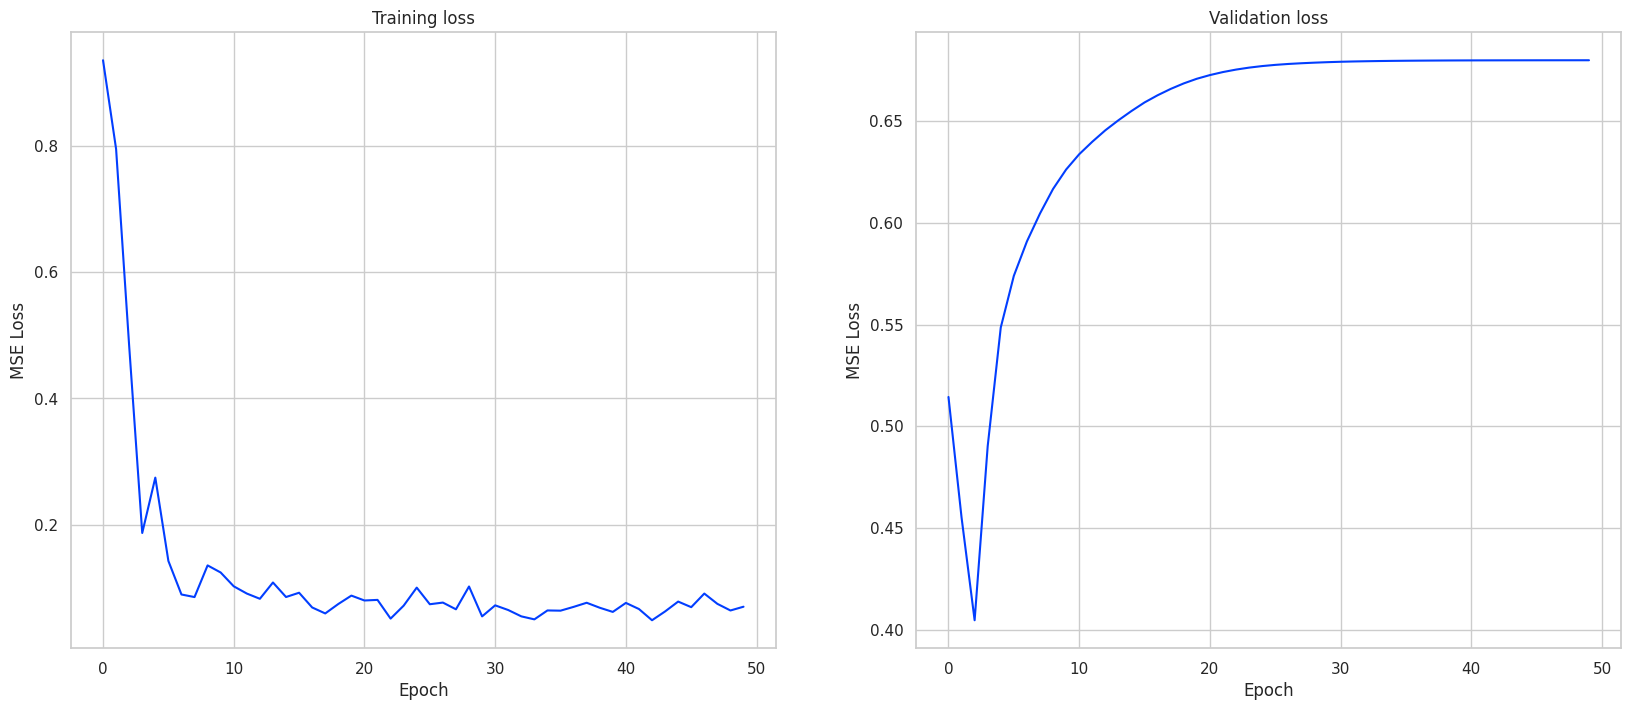

In [401]:
fig, ax=plt.subplots(1,2, figsize=(20,8))
# ax[0].plot(trainer.train_plot)
ax[0].plot(train_loss_plot)
ax[0].set_ylabel("MSE Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Training loss")

ax[1].plot(val_loss_plot)
ax[1].set_ylabel("MSE Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Validation loss")


### **Evaluate and Inference**

In [402]:
prediction,true_labels=test(test_loader)
prediction = prediction.reshape(-1)
true_labels = true_labels.reshape(-1)
print(prediction.shape, true_labels.shape)
tfidf_test_metrics=get_metrics(prediction,true_labels)
tfidf_test_metrics

Train:   0%|          | 0/3 [00:00<?, ?it/s]

(59,) (59,)


MSE       RMSE        MAE      MAPE  Serial Corr  Pearson Corr(IC),  \
0  208.998901  14.456794  12.337156  0.355732     0.237816          -0.136563   

   Spearman Corr(IC)  
0           -0.16528

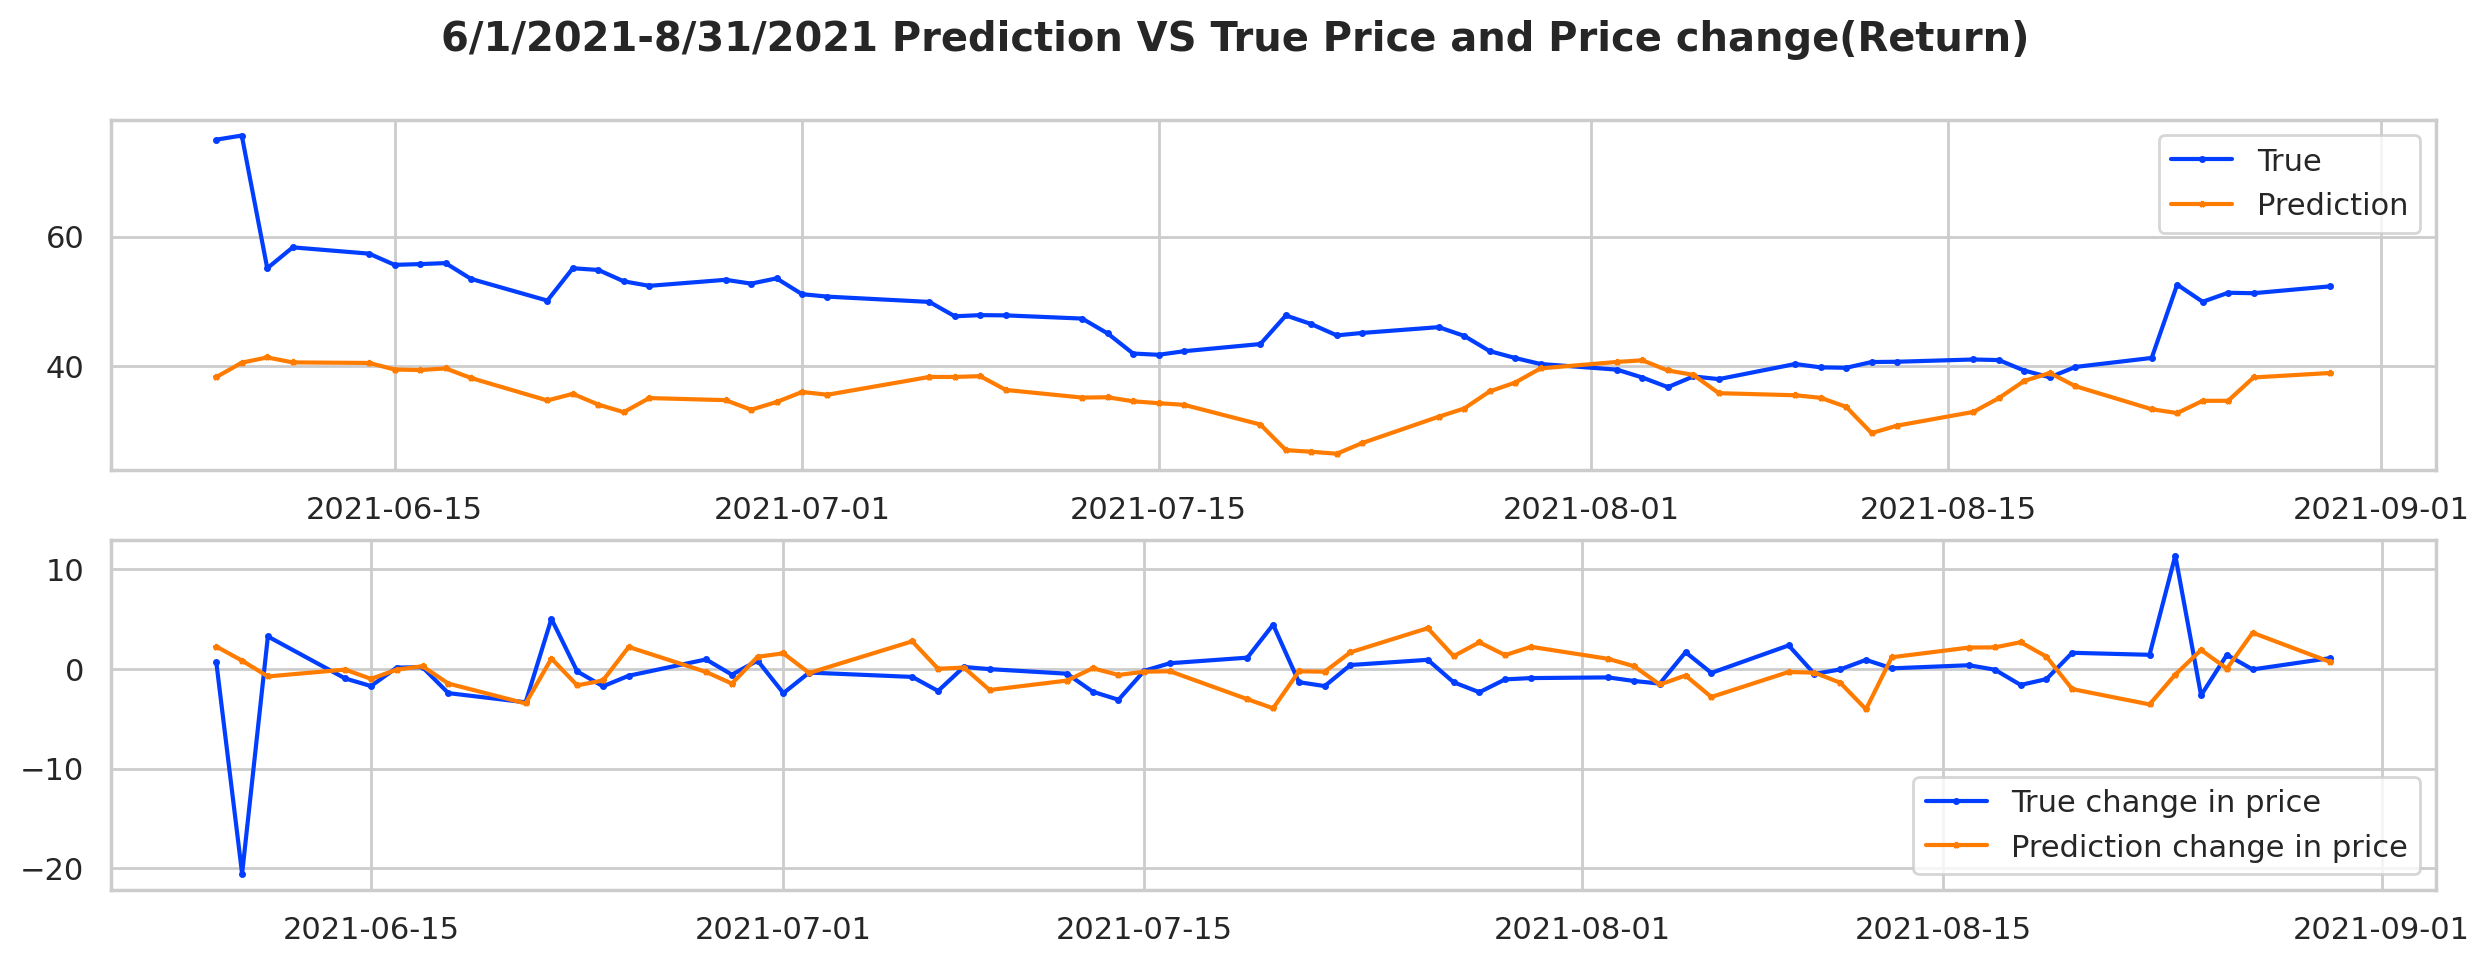

In [403]:
fig,ax=plt.subplots(2,1, figsize=(15,5),dpi=200)
date = df_ts[(df_ts.index>=pd.to_datetime("2021-06-08")) & (df_ts.index<=pd.to_datetime("2021-08-30"))].reset_index()['Date']
ax[0].plot(date, true_labels, label='True', marker='.', markersize=3)
ax[0].plot(date, prediction, label='Prediction',marker='*', markersize=2)
ax[0].legend()

ax[1].plot(date[1:], np.diff(true_labels), label='True change in price', marker='.', markersize=3)
ax[1].plot(date[1:],np.diff(prediction), label='Prediction change in price',marker='*', markersize=2)
ax[1].legend()
fig.suptitle("6/1/2021-8/31/2021 Prediction VS True Price and Price change(Return)", fontweight="bold")
plt.show()

In [404]:
inference_indices = get_windows(df_ts[df_ts.index<pd.to_datetime('2021-09-01')], window_len, step_size=pred_len)

inference_data=TSDataset(torch.FloatTensor(np.array(df_ts[df_ts.index<pd.to_datetime('2021-09-01')].values)), inference_indices, window_len, pred_len=pred_len)

inference_loader = torch.utils.data.DataLoader(
    dataset     = inference_data,
    batch_size  = len(inference_data),
    pin_memory  = False,
    shuffle=False
)
# inference_indices

In [405]:
prediction,true_labels=test(inference_loader)
prediction = prediction.reshape(-1)
true_labels = true_labels.reshape(-1)
print(prediction.shape, true_labels.shape)
tfidf_train_test_metrics=get_metrics(prediction,true_labels)
tfidf_train_test_metrics

Train:   0%|          | 0/1 [00:00<?, ?it/s]

(149,) (149,)


MSE       RMSE       MAE      MAPE  Serial Corr  Pearson Corr(IC),  \
0  155.611191  12.474421  8.664913  0.262215     0.766102           0.598092   

   Spearman Corr(IC)  
0           0.284171

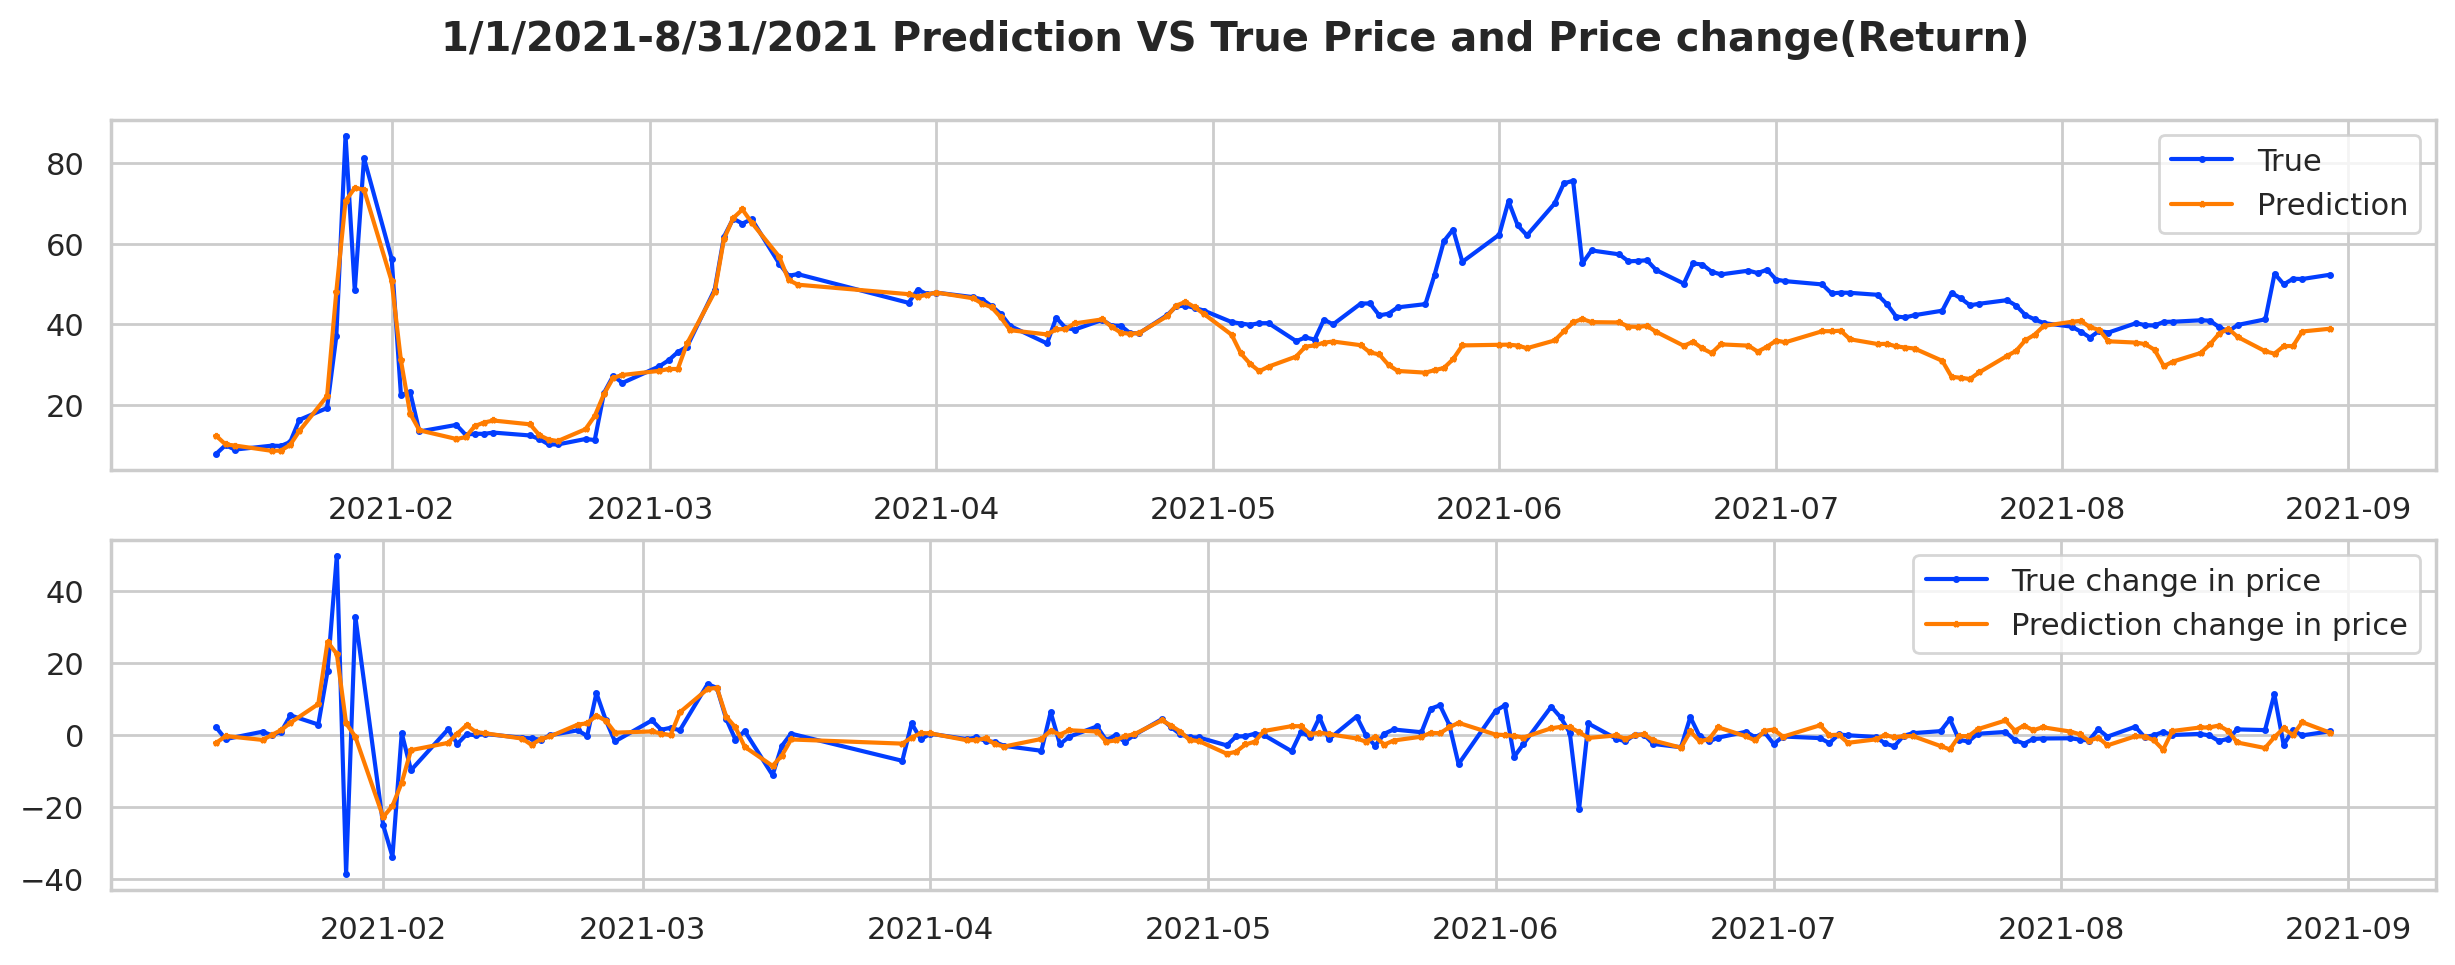

In [406]:
fig,ax=plt.subplots(2,1, figsize=(15,5),dpi=200)
date = df_ts[(df_ts.index>=pd.to_datetime("2021-01-13")) & (df_ts.index<=pd.to_datetime("2021-08-30"))].reset_index()['Date']
ax[0].plot(date,true_labels, label='True', marker='.', markersize=3)
ax[0].plot(date,prediction, label='Prediction',marker='*', markersize=2)
ax[0].legend()

ax[1].plot(date[1:], np.diff(true_labels), label='True change in price', marker='.', markersize=3)
ax[1].plot(date[1:], np.diff(prediction), label='Prediction change in price',marker='*', markersize=2)
ax[1].legend()
fig.suptitle("1/1/2021-8/31/2021 Prediction VS True Price and Price change(Return)", fontweight="bold")
plt.show()

# **Explore Bert Embeddings**

In [407]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert = BertModel.from_pretrained("bert-base-uncased").to(device)

## **Load my fine-tuned Bert to generate embeddings**

In [408]:
def tokenize(x):
  out = tokenizer.encode_plus(x,
        add_special_tokens=True,  # Add [CLS] and [SEP] tokens
        max_length=50,    # Truncate or pad to the maximum length
        truncation=True,          # Enable truncation if text is too long
        padding='max_length',     # Pad to the maximum length
        return_tensors='pt'       # Return PyTorch tensors)
  )
  return out
df_tokenized = df['title'].apply(lambda x: tokenize(x))
df_vec = df_tokenized.values
print("Shape of tokenized vector:",df_vec.shape)
print("shape of one news:", df_vec[0]['input_ids'].shape)
df_vec[0]

Shape of tokenized vector: (65025,)
shape of one news: torch.Size([1, 50])


{'input_ids': tensor([[  101,  2460, 11025, 14932,  7596,  7596,  7596,  7596,  7596,  7596,
          7596,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

In [409]:
class BERT(nn.Module):
    def __init__(self, bert):
        super(BERT, self).__init__()
        self.bert = bert
        self.mlp = nn.Sequential(
            nn.Linear(768,256),
            nn.LeakyReLU(),
            nn.Linear(256,256),
            nn.LeakyReLU(),
            nn.Linear(256,3)
        )

    def forward(self, x):
        input_ids= x[0].to(device)
        token_type= x[1].to(device)
        att_mask= x[2].to(device)
        out = self.bert(input_ids.to(device),  attention_mask=att_mask.to(device), token_type_ids=token_type.to(device))

        return self.mlp(out.pooler_output)

In [410]:
model = torch.load("/content/drive/MyDrive/94812/prediction/bert_finetuned.pt")
model((df_vec[0].input_ids.to(device), df_vec[0].token_type_ids.to(device), df_vec[0].attention_mask.to(device)))

tensor([[ 1.9833, -1.3301, -0.9498]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [411]:
class NLPDataset(torch.utils.data.Dataset):
    def __init__(self, data) :
        super().__init__()
        self.data = data
        self.input_ids = torch.vstack([i['input_ids'].squeeze() for i in data])
        self.token_type_ids = torch.vstack([i['token_type_ids'].squeeze() for i in data])
        self.att_mask = torch.vstack([i['attention_mask'].squeeze() for i in data])
        # self.label = torch.LongTensor(label)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):

        return (self.input_ids[index].to(device), self.token_type_ids[index].to(device), self.att_mask[index].to(device))

In [412]:
inference_data = NLPDataset(df_vec)
inference_loader = torch.utils.data.DataLoader(
    dataset     = inference_data,
    batch_size  = 256,
    shuffle=False
)
len(inference_data)
for X in inference_loader:
  print(len(X))
  print(X[0].shape, X[1].shape, X[2].shape)
  break
model.bert(input_ids=X[0], token_type_ids=X[1], attention_mask=X[2]).pooler_output.shape

3
torch.Size([256, 50]) torch.Size([256, 50]) torch.Size([256, 50])


torch.Size([256, 768])

In [413]:
embeddings = []
for X in tqdm(inference_loader, "inferencing..."):
  with torch.no_grad():
    res = model.bert(input_ids=X[0], token_type_ids=X[1], attention_mask=X[2]).pooler_output.cpu().detach().numpy()
    # print(res.shape)
    embeddings .append(res)
    del X
    gc.collect()
    torch.cuda.empty_cache()

embeddings = np.vstack(embeddings )
embeddings.shape

inferencing...:   0%|          | 0/255 [00:00<?, ?it/s]

(65025, 768)

## **Combine Time Series with Bert Embeddings.**

In [414]:
df_embeddings = pd.DataFrame(embeddings,columns=['dim'+str(i) for i in range(embeddings.shape[-1])])
df_embeddings['Date'] = df['Date']
df_embeddings = df_embeddings.groupby('Date').mean()
df_embeddings

dim0      dim1      dim2      dim3      dim4      dim5  \
Date                                                                     
2021-01-04 -0.839527 -0.424083 -0.761567  0.662155  0.450761 -0.177779   
2021-01-05 -0.645647 -0.214557  0.052024  0.301909 -0.188323  0.077009   
2021-01-06 -0.628741 -0.299113 -0.654147  0.409663  0.445411 -0.050049   
2021-01-11 -0.802747 -0.291301 -0.455577  0.563209  0.237437 -0.076465   
2021-01-12 -0.769426 -0.150443 -0.014803  0.306195 -0.156165 -0.082009   
...              ...       ...       ...       ...       ...       ...   
2021-12-27 -0.728161 -0.216403 -0.062830  0.461112  0.074148 -0.062493   
2021-12-28 -0.705196 -0.201016 -0.055921  0.437542  0.089978 -0.068063   
2021-12-29 -0.708982 -0.211265 -0.067367  0.458725  0.059540 -0.070933   
2021-12-30 -0.721261 -0.209991 -0.100055  0.453505  0.088307 -0.065612   
2021-12-31 -0.739738 -0.220709 -0.061747  0.465211  0.063474 -0.053319   

                dim6      dim7      dim8      dim9  ...    dim758    dim759  \
Date                                                ...                       
2021-01-04  0.661404  0.180796 -0.404010 -0.999967  ...  0.349083  0.094895   
2021-01-05  0.432468  0.036705  0.245787 -0.998497  ...  0.288688  0.605945   
2021-01-06  0.378659  0.173903 -0.174406 -0.997786  ...  0.396931  0.087815   
2021-01-11  0.544653  0.194068 -0.086913 -0.999832  ...  0.358911  0.071618   
2021-01-12  0.612291  0.131569  0.166596 -0.999605  ...  0.380514  0.499363   
...              ...       ...       ...       ...  ...       ...       ...   
2021-12-27  0.547355  0.104609  0.166641 -0.998253  ...  0.288410  0.368259   
2021-12-28  0.496384  0.098195  0.193123 -0.996345  ...  0.286842  0.415341   
2021-12-29  0.536624  0.105422  0.188381 -0.995427  ...  0.297249  0.428893   
2021-12-30  0.518924  0.120476  0.198362 -0.997953  ...  0.296497  0.414959   
2021-12-31  0.580735  0.118421  0.199280 -0.997153  ...  0.302011  0.339251   

              dim760    dim761    dim762    dim763    dim764    dim765  \
Date                                                                     
2021-01-04  0.929867  0.693200  0.033616  0.395849  0.379404 -0.602982   
2021-01-05 -0.044362  0.676697  0.785801  0.708676  0.422682 -0.098632   
2021-01-06  0.784068  0.727849 -0.380828  0.351390  0.450142 -0.663287   
2021-01-11  0.611937  0.734785  0.055054  0.554327  0.425337 -0.025344   
2021-01-12  0.112339  0.703219  0.009969  0.433367  0.419007  0.258986   
...              ...       ...       ...       ...       ...       ...   
2021-12-27  0.361061  0.768477  0.160681  0.622048  0.389803 -0.038329   
2021-12-28  0.337892  0.749499  0.181303  0.625530  0.389209 -0.066094   
2021-12-29  0.295342  0.753091  0.165046  0.606768  0.404431 -0.076506   
2021-12-30  0.355545  0.758762  0.171291  0.625071  0.398163 -0.085958   
2021-12-31  0.362472  0.776954  0.206043  0.652671  0.395210 -0.023866   

              dim766    dim767  
Date                            
2021-01-04 -0.601221  0.744309  
2021-01-05 -0.463653  0.738352  
2021-01-06 -0.467869  0.636216  
2021-01-11 -0.559318  0.834198  
2021-01-12 -0.452421  0.703244  
...              ...       ...  
2021-12-27 -0.496534  0.794707  
2021-12-28 -0.494705  0.779706  
2021-12-29 -0.503286  0.788096  
2021-12-30 -0.497265  0.792552  
2021-12-31 -0.508419  0.812573  

[240 rows x 768 columns]

In [415]:
dff = df[df.columns.difference(['title'])].groupby('Date').mean()
df_full = pd.concat([dff, df_embeddings],axis=1)
df_full

Close       High        Low       Open      Volume      dim0  \
Date                                                                           
2021-01-04   4.312500   4.775000   4.287500   4.750000  40090000.0 -0.839527   
2021-01-05   4.342500   4.520000   4.307500   4.337500  19846000.0 -0.645647   
2021-01-06   4.590000   4.745000   4.332500   4.335000  24224800.0 -0.628741   
2021-01-11   4.985000   5.162500   4.752500   4.852500  59632000.0 -0.802747   
2021-01-12   4.987500   5.100000   4.830000   4.990000  28242800.0 -0.769426   
...               ...        ...        ...        ...         ...       ...   
2021-12-27  37.077499  38.154999  35.000000  38.000000   6454400.0 -0.728161   
2021-12-28  36.615002  39.352501  36.602501  36.875000   5324400.0 -0.705196   
2021-12-29  38.482498  38.872501  35.535000  36.962502   8149600.0 -0.708982   
2021-12-30  38.832500  40.000000  37.500000  37.750000   6247600.0 -0.721261   
2021-12-31  37.097500  39.182499  37.025002  38.404999   5576000.0 -0.739738   

                dim1      dim2      dim3      dim4  ...    dim758    dim759  \
Date                                                ...                       
2021-01-04 -0.424083 -0.761567  0.662155  0.450761  ...  0.349083  0.094895   
2021-01-05 -0.214557  0.052024  0.301909 -0.188323  ...  0.288688  0.605945   
2021-01-06 -0.299113 -0.654147  0.409663  0.445411  ...  0.396931  0.087815   
2021-01-11 -0.291301 -0.455577  0.563209  0.237437  ...  0.358911  0.071618   
2021-01-12 -0.150443 -0.014803  0.306195 -0.156165  ...  0.380514  0.499363   
...              ...       ...       ...       ...  ...       ...       ...   
2021-12-27 -0.216403 -0.062830  0.461112  0.074148  ...  0.288410  0.368259   
2021-12-28 -0.201016 -0.055921  0.437542  0.089978  ...  0.286842  0.415341   
2021-12-29 -0.211265 -0.067367  0.458725  0.059540  ...  0.297249  0.428893   
2021-12-30 -0.209991 -0.100055  0.453505  0.088307  ...  0.296497  0.414959   
2021-12-31 -0.220709 -0.061747  0.465211  0.063474  ...  0.302011  0.339251   

              dim760    dim761    dim762    dim763    dim764    dim765  \
Date                                                                     
2021-01-04  0.929867  0.693200  0.033616  0.395849  0.379404 -0.602982   
2021-01-05 -0.044362  0.676697  0.785801  0.708676  0.422682 -0.098632   
2021-01-06  0.784068  0.727849 -0.380828  0.351390  0.450142 -0.663287   
2021-01-11  0.611937  0.734785  0.055054  0.554327  0.425337 -0.025344   
2021-01-12  0.112339  0.703219  0.009969  0.433367  0.419007  0.258986   
...              ...       ...       ...       ...       ...       ...   
2021-12-27  0.361061  0.768477  0.160681  0.622048  0.389803 -0.038329   
2021-12-28  0.337892  0.749499  0.181303  0.625530  0.389209 -0.066094   
2021-12-29  0.295342  0.753091  0.165046  0.606768  0.404431 -0.076506   
2021-12-30  0.355545  0.758762  0.171291  0.625071  0.398163 -0.085958   
2021-12-31  0.362472  0.776954  0.206043  0.652671  0.395210 -0.023866   

              dim766    dim767  
Date                            
2021-01-04 -0.601221  0.744309  
2021-01-05 -0.463653  0.738352  
2021-01-06 -0.467869  0.636216  
2021-01-11 -0.559318  0.834198  
2021-01-12 -0.452421  0.703244  
...              ...       ...  
2021-12-27 -0.496534  0.794707  
2021-12-28 -0.494705  0.779706  
2021-12-29 -0.503286  0.788096  
2021-12-30 -0.497265  0.792552  
2021-12-31 -0.508419  0.812573  

[240 rows x 773 columns]

In [416]:
df_ts=df_full[df_full.columns.difference(['Date'])].reset_index()
# df_ts=df_full.reset_index()
df_ts['Date'] = pd.to_datetime(df_ts['Date'])
# df_ts['sentiment'] = df_sentiment['sentiment']
df_ts.index=df_ts['Date']
df_ts = df_ts.drop(columns='Date')
df_ts

Close       High        Low       Open      Volume      dim0  \
Date                                                                           
2021-01-04   4.312500   4.775000   4.287500   4.750000  40090000.0 -0.839527   
2021-01-05   4.342500   4.520000   4.307500   4.337500  19846000.0 -0.645647   
2021-01-06   4.590000   4.745000   4.332500   4.335000  24224800.0 -0.628741   
2021-01-11   4.985000   5.162500   4.752500   4.852500  59632000.0 -0.802747   
2021-01-12   4.987500   5.100000   4.830000   4.990000  28242800.0 -0.769426   
...               ...        ...        ...        ...         ...       ...   
2021-12-27  37.077499  38.154999  35.000000  38.000000   6454400.0 -0.728161   
2021-12-28  36.615002  39.352501  36.602501  36.875000   5324400.0 -0.705196   
2021-12-29  38.482498  38.872501  35.535000  36.962502   8149600.0 -0.708982   
2021-12-30  38.832500  40.000000  37.500000  37.750000   6247600.0 -0.721261   
2021-12-31  37.097500  39.182499  37.025002  38.404999   5576000.0 -0.739738   

                dim1     dim10    dim100    dim101  ...     dim90     dim91  \
Date                                                ...                       
2021-01-04 -0.424083 -0.238887 -0.017671 -0.157559  ...  0.411837 -0.069524   
2021-01-05 -0.214557  0.367529  0.034623 -0.121090  ...  0.201836 -0.036980   
2021-01-06 -0.299113 -0.249750  0.054943 -0.112898  ...  0.491068 -0.149110   
2021-01-11 -0.291301  0.072107  0.027417 -0.150878  ...  0.355077 -0.127279   
2021-01-12 -0.150443  0.197225  0.005379 -0.144763  ...  0.340767 -0.075115   
...              ...       ...       ...       ...  ...       ...       ...   
2021-12-27 -0.216403  0.158987 -0.011314 -0.063328  ...  0.350869 -0.043276   
2021-12-28 -0.201016  0.188550 -0.020295 -0.060481  ...  0.344031 -0.025892   
2021-12-29 -0.211265  0.161865 -0.017330 -0.074440  ...  0.334601 -0.041553   
2021-12-30 -0.209991  0.175779 -0.015388 -0.058831  ...  0.347713 -0.033347   
2021-12-31 -0.220709  0.161016 -0.026078 -0.075404  ...  0.346655 -0.040661   

               dim92     dim93     dim94     dim95     dim96     dim97  \
Date                                                                     
2021-01-04  0.357766  0.383963 -0.166471 -0.393023 -0.226149 -0.780693   
2021-01-05  0.128356  0.302147 -0.080309 -0.184914 -0.023092  0.216623   
2021-01-06  0.356828  0.362787 -0.197846 -0.385284 -0.125539 -0.496077   
2021-01-11 -0.042195  0.354187 -0.091750 -0.312719 -0.179920 -0.366954   
2021-01-12 -0.024135  0.394696 -0.292610 -0.294580 -0.139294  0.256641   
...              ...       ...       ...       ...       ...       ...   
2021-12-27 -0.093588  0.295031 -0.016950 -0.212116 -0.091879 -0.107956   
2021-12-28 -0.082073  0.305721 -0.019929 -0.217743 -0.075754 -0.111919   
2021-12-29 -0.038016  0.311280 -0.064644 -0.217771 -0.084293 -0.091970   
2021-12-30 -0.051813  0.305904 -0.039449 -0.226896 -0.083790 -0.124844   
2021-12-31 -0.139071  0.303449  0.001471 -0.199645 -0.093357 -0.118642   

               dim98     dim99  
Date                            
2021-01-04 -0.221504 -0.268770  
2021-01-05 -0.105075  0.096137  
2021-01-06 -0.287380 -0.247983  
2021-01-11 -0.195913 -0.225368  
2021-01-12 -0.172245 -0.037738  
...              ...       ...  
2021-12-27 -0.165457 -0.161734  
2021-12-28 -0.161259 -0.173406  
2021-12-29 -0.158844 -0.171413  
2021-12-30 -0.160525 -0.178042  
2021-12-31 -0.163419 -0.154025  

[240 rows x 773 columns]

# **Training with Bert embeddings**

### **Train Test Split**

In [434]:
total_len = len(df_ts)

train = df_ts[df_ts.index<pd.to_datetime("2021-05-01")]
val   = df_ts[(df_ts.index < pd.to_datetime("2021-06-01")) & (df_ts.index > pd.to_datetime("2021-05-01"))]
test  = df_ts[(df_ts.index < pd.to_datetime("2021-09-01")) & (df_ts.index > pd.to_datetime("2021-05-31"))]
print("train_len",len(train)/total_len,"val_len", len(val)/total_len,"test_len", len(test)/total_len)

train_len 0.2916666666666667 val_len 0.08333333333333333 test_len 0.2708333333333333


In [435]:
X_train = np.array(train.values)
X_val = np.array(val.values)
X_test = np.array(test.values)
factor_name = train.columns
print(factor_name)
X_train.shape, X_val.shape, X_test.shape


Index(['Close', 'High', 'Low', 'Open', 'Volume', 'dim0', 'dim1', 'dim10',
       'dim100', 'dim101',
       ...
       'dim90', 'dim91', 'dim92', 'dim93', 'dim94', 'dim95', 'dim96', 'dim97',
       'dim98', 'dim99'],
      dtype='object', length=773)


((70, 773), (20, 773), (65, 773))

In [436]:
train_mean = np.mean(X_train, axis=0, keepdims = True)
train_std = np.std(X_train, axis=0, keepdims = True)

### **Dataset & DataLoader**

In [437]:
class TSDataset(torch.utils.data.Dataset):
    def __init__(self, data, indices, seq_len, pred_len=20) :
        super().__init__()
        self.data = (data-torch.FloatTensor(train_mean))/torch.FloatTensor(train_std)
        self.indices = indices
        self.seq_len = seq_len
        self.pred_len= pred_len

    def __len__(self):
        return len(self.indices)

    def get_sequence(self, sequence, seq_len) :

        x = sequence[0:-self.pred_len,:]     #0~7 close open high low volume
        y = sequence[self.pred_len:,0]     #8 close

        return x, y

    def __getitem__(self, index):
        start, end = self.indices[index]
        sequence = self.data[start:end]
        x, y = self.get_sequence(sequence, self.seq_len)

        return x, y

def get_windows(data, window_size, step_size=1):
    # Start the first sub-sequence at index position 0
    start = 0
    end = window_size

    indices = []
    while end <= len(data)-1:      #proceed window by step size, count how many sequences
        indices.append((start, end))
        start += step_size
        end += step_size
    return indices

[(0, 6), (1, 7), (2, 8), (3, 9), (4, 10), (5, 11), (6, 12), (7, 13), (8, 14), (9, 15), (10, 16), (11, 17), (12, 18), (13, 19), (14, 20), (15, 21), (16, 22), (17, 23), (18, 24), (19, 25), (20, 26), (21, 27), (22, 28), (23, 29), (24, 30), (25, 31), (26, 32), (27, 33), (28, 34), (29, 35), (30, 36), (31, 37), (32, 38), (33, 39), (34, 40), (35, 41), (36, 42), (37, 43), (38, 44), (39, 45), (40, 46), (41, 47), (42, 48), (43, 49), (44, 50), (45, 51), (46, 52), (47, 53), (48, 54), (49, 55), (50, 56), (51, 57), (52, 58), (53, 59), (54, 60), (55, 61), (56, 62), (57, 63), (58, 64), (59, 65), (60, 66), (61, 67), (62, 68), (63, 69)]
torch.Size([64, 5]) torch.Size([64, 5, 773])
x:  tensor([-0.9922, -0.9757, -1.0123, -1.0574, -1.1239])
y_train:  tensor([-0.9757, -1.0123, -1.0574, -1.1239, -1.1251])


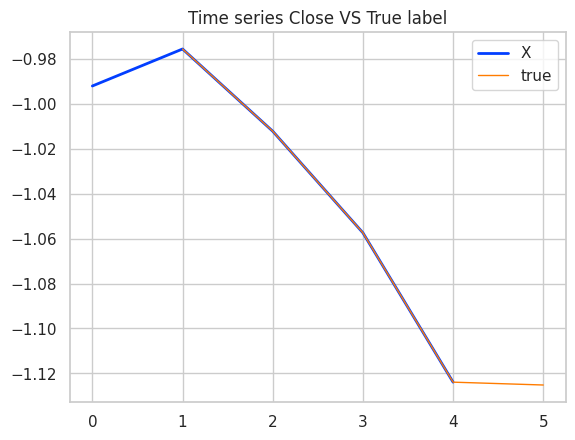

In [438]:
config = {
  'batch_size': 64,
  'lr':2e-3,
  'epochs': 30,
}
#TODO: tune context_len and pred_len
context_len=5
pred_len=1
window_len=context_len+pred_len
training_indices = get_windows(X_train, window_len, step_size=1) #TODO: Tune step size...
val_indices = get_windows(X_val,window_len, step_size=1) #TODO: Tune step size...
test_indices = get_windows(X_test, window_len, step_size=pred_len)

print(training_indices)
train_data=TSDataset(torch.FloatTensor(X_train), training_indices, window_len, pred_len=pred_len)
val_data=TSDataset(torch.FloatTensor(X_val), val_indices, window_len, pred_len=pred_len)
test_data=TSDataset(torch.FloatTensor(X_test), test_indices, window_len, pred_len=pred_len)

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config['batch_size'],
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = 24,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset     = test_data,
    batch_size  = 24,
    pin_memory  = False,
    shuffle=False
)

for batch in train_loader:
    x, y_train=batch
    print(y_train.shape, x.shape)
    print("x: ", x[0,:,0]) #0 is the closing price
    print("y_train: ", y_train[0,:])  #True label should shift by one to right
    plt.plot(x[0,:,0], linewidth=2, label ="X")
    plt.plot(np.arange(pred_len, window_len), y_train[0,:], linewidth=1, label ="true")
    plt.legend()
    plt.title("Time series Close VS True label")
    break

### **LSTM Model**

In [439]:
class LSTM_Block(nn.Module):
  def __init__(self, input_dim, output_dim, dropout=0.3):
    super(LSTM_Block, self).__init__()
    self.lstm = nn.LSTM(input_dim, output_dim, num_layers=1, dropout=dropout, bias=True, batch_first=True)
    # self.bn= nn.BatchNorm1d(output_dim)
    self.dp = nn.Dropout(dropout)
    # self.act = nn.LeakyReLU()
  def forward(self, x):
    out,_ = self.lstm(x)
    # out = self.bn(out.permute(0,2,1)).permute(0,2,1)
    out = self.dp(out)
    # out = self.act(out)
    return out

class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=512, dropout=0.3):
        super(LSTM, self).__init__()
        self.d_model=d_model
        self.model = torch.nn.Sequential(

            LSTM_Block(input_dim, d_model),
            LSTM_Block(d_model, d_model),
            nn.Linear(d_model,d_model),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model,output_dim)
        )
        # self.linear_scale = nn.Linear(2,1)
        # self.linear_out = nn.Linear(context_len*d_model, output_dim)

    def forward(self, x):
        return self.model(x) #+ x[:,:,0:1]
        # return self.linear_out(self.model(x).flatten(1)).unsqueeze(1) #+ x[:,:,0:1]
        # return self.linear_scale(torch.cat([self.model(x) , x[:,:,0:1]],dim=-1))


In [440]:
#TODO: tune model parameters
model=LSTM(input_dim=X_train.shape[-1], output_dim=1, d_model=512, dropout=0.5).to(device)
# print(x.size)
for x, y in train_loader:
    x=torch.FloatTensor(x).to(device)
    y=torch.FloatTensor(y).to(device)
    print(x[0,:,0], y[0])
    print("x shape:",x.shape, "y shape:", y.shape)
    out=model(x)
    print("out shape:", out.shape)
    summary(model,x)
    break

tensor([-0.8796, -1.0022, -0.9909, -0.9922, -0.9757], device='cuda:0') tensor([-1.0022, -0.9909, -0.9922, -0.9757, -1.0123], device='cuda:0')
x shape: torch.Size([64, 5, 773]) y shape: torch.Size([64, 5])
out shape: torch.Size([64, 5, 1])
                     Kernel Shape  Output Shape     Params  Mult-Adds
Layer                                                                
0_model.0.LSTM_lstm             -  [64, 5, 512]  2.635776M   2.63168M
1_model.0.Dropout_dp            -  [64, 5, 512]          -          -
2_model.1.LSTM_lstm             -  [64, 5, 512]  2.101248M  2.097152M
3_model.1.Dropout_dp            -  [64, 5, 512]          -          -
4_model.Linear_2       [512, 512]  [64, 5, 512]   262.656k   262.144k
5_model.LeakyReLU_3             -  [64, 5, 512]          -          -
6_model.Dropout_4               -  [64, 5, 512]          -          -
7_model.Linear_5         [512, 1]    [64, 5, 1]      513.0      512.0
-------------------------------------------------------------

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


In [441]:
optimizer   = torch.optim.AdamW(model.parameters(), lr= config['lr'], weight_decay = 1e-3)
criterion   = torch.nn.MSELoss()
scaler      = torch.cuda.amp.GradScaler()
scheduler   = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
# Optional (but Recommended): Create a custom class for a Teacher Force Schedule

In [442]:
def train():
      model.train() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(train_loader):
          optimizer.zero_grad()

          x, y_train = batch

          x = x.to(device)
          y_train = y_train.to(device)
          y_pred = model(x)

          loss = criterion(y_pred[:,-pred_len:], y_train.unsqueeze(-1)[:,-pred_len:])   #TODO: try changing 8 to others, if want the model to learn other columns
          loss.backward()
          optimizer.step()

          # train_plot.append(loss.item())
          running_loss += loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1)),
              lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
              # teacher_time="{:.04f}".format(teach/10)
               )
          batch_bar.update()

          del x, y_train, y_pred
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(train_loader)

def validate():
      model.eval() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(val_loader):
          optimizer.zero_grad()
          x, y_test = batch

          x = x.to(device)
          y_test = y_test.to(device)

          y_pred = model(x)
          val_loss = criterion(y_pred[:,-pred_len:], y_test.unsqueeze(-1)[:,-pred_len:])    #TODO: try changing 8 to others, if want the model to learn other columns

          running_loss += val_loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1))
               )
          batch_bar.update()

          del x, y_test
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(val_loader)

def test(test_loader):
        model.eval() # set to training mode
        model.to(device)
        batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
        prediction=[]
        true_labels = []
        for i, batch in enumerate(test_loader):
            optimizer.zero_grad()
            x, y_test = batch
            x = x.to(device)

            y_pred = model(x)[:,:,0] #take tomorrow
            prediction.append(y_pred[:,-pred_len:].cpu().detach().numpy())
            true_labels.append(y_test[:,-pred_len:].cpu().detach().numpy())

            del x, y_test
            torch.cuda.empty_cache()
            batch_bar.update()

        batch_bar.close()


        return np.concatenate(prediction)*train_std[0][0]+train_mean[0][0], \
               np.concatenate(true_labels)*train_std[0][0]+train_mean[0][0]

### **Train Loop**

In [443]:
# optimizer.param_groups[0]['lr']=1e-4
train_loss_plot=[]
val_loss_plot=[]
num_epochs=50
for epoch in range(0, num_epochs):

    # Call train and validate
    print("\nEpoch: {}/{}".format(epoch+1, num_epochs))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_loss              = train()
    train_loss_plot.append(train_loss)

    val_loss              = validate()
    val_loss_plot.append(val_loss)

    # trainer.teacher_forcing_ratio=max(trainer.teacher_forcing_ratio-0.05,0.1)
    scheduler.step()

    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}\t Validation Loss {:.04f}".format(train_loss, curr_lr, val_loss))



Epoch: 1/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.9205	 Learning Rate 0.0020000	 Validation Loss 0.3215

Epoch: 2/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.7593	 Learning Rate 0.0016000	 Validation Loss 0.2418

Epoch: 3/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.6442	 Learning Rate 0.0012800	 Validation Loss 0.1394

Epoch: 4/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4438	 Learning Rate 0.0010240	 Validation Loss 0.1764

Epoch: 5/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3255	 Learning Rate 0.0008192	 Validation Loss 0.1405

Epoch: 6/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2645	 Learning Rate 0.0006554	 Validation Loss 0.1052

Epoch: 7/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1798	 Learning Rate 0.0005243	 Validation Loss 0.1129

Epoch: 8/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1408	 Learning Rate 0.0004194	 Validation Loss 0.1377

Epoch: 9/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1542	 Learning Rate 0.0003355	 Validation Loss 0.1352

Epoch: 10/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1636	 Learning Rate 0.0002684	 Validation Loss 0.1176

Epoch: 11/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1359	 Learning Rate 0.0002147	 Validation Loss 0.1029

Epoch: 12/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1222	 Learning Rate 0.0001718	 Validation Loss 0.1002

Epoch: 13/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1153	 Learning Rate 0.0001374	 Validation Loss 0.1071

Epoch: 14/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1053	 Learning Rate 0.0001100	 Validation Loss 0.1160

Epoch: 15/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1102	 Learning Rate 0.0000880	 Validation Loss 0.1226

Epoch: 16/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1322	 Learning Rate 0.0000704	 Validation Loss 0.1262

Epoch: 17/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1302	 Learning Rate 0.0000563	 Validation Loss 0.1268

Epoch: 18/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1063	 Learning Rate 0.0000450	 Validation Loss 0.1256

Epoch: 19/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1107	 Learning Rate 0.0000360	 Validation Loss 0.1240

Epoch: 20/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0957	 Learning Rate 0.0000288	 Validation Loss 0.1220

Epoch: 21/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1032	 Learning Rate 0.0000231	 Validation Loss 0.1203

Epoch: 22/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1098	 Learning Rate 0.0000184	 Validation Loss 0.1187

Epoch: 23/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1028	 Learning Rate 0.0000148	 Validation Loss 0.1173

Epoch: 24/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0909	 Learning Rate 0.0000118	 Validation Loss 0.1162

Epoch: 25/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1203	 Learning Rate 0.0000094	 Validation Loss 0.1153

Epoch: 26/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1106	 Learning Rate 0.0000076	 Validation Loss 0.1146

Epoch: 27/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1044	 Learning Rate 0.0000060	 Validation Loss 0.1139

Epoch: 28/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1076	 Learning Rate 0.0000048	 Validation Loss 0.1134

Epoch: 29/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0682	 Learning Rate 0.0000039	 Validation Loss 0.1131

Epoch: 30/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0815	 Learning Rate 0.0000031	 Validation Loss 0.1128

Epoch: 31/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0973	 Learning Rate 0.0000025	 Validation Loss 0.1126

Epoch: 32/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0889	 Learning Rate 0.0000020	 Validation Loss 0.1124

Epoch: 33/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0980	 Learning Rate 0.0000016	 Validation Loss 0.1123

Epoch: 34/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0973	 Learning Rate 0.0000013	 Validation Loss 0.1122

Epoch: 35/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1098	 Learning Rate 0.0000010	 Validation Loss 0.1121

Epoch: 36/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1093	 Learning Rate 0.0000008	 Validation Loss 0.1120

Epoch: 37/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1117	 Learning Rate 0.0000006	 Validation Loss 0.1119

Epoch: 38/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1046	 Learning Rate 0.0000005	 Validation Loss 0.1119

Epoch: 39/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1114	 Learning Rate 0.0000004	 Validation Loss 0.1119

Epoch: 40/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0802	 Learning Rate 0.0000003	 Validation Loss 0.1118

Epoch: 41/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0938	 Learning Rate 0.0000003	 Validation Loss 0.1118

Epoch: 42/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0879	 Learning Rate 0.0000002	 Validation Loss 0.1118

Epoch: 43/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0889	 Learning Rate 0.0000002	 Validation Loss 0.1118

Epoch: 44/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0926	 Learning Rate 0.0000001	 Validation Loss 0.1118

Epoch: 45/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0911	 Learning Rate 0.0000001	 Validation Loss 0.1117

Epoch: 46/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0588	 Learning Rate 0.0000001	 Validation Loss 0.1117

Epoch: 47/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1117	 Learning Rate 0.0000001	 Validation Loss 0.1117

Epoch: 48/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0715	 Learning Rate 0.0000001	 Validation Loss 0.1117

Epoch: 49/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1301	 Learning Rate 0.0000000	 Validation Loss 0.1117

Epoch: 50/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1127	 Learning Rate 0.0000000	 Validation Loss 0.1117


Text(0.5, 1.0, 'Validation loss')

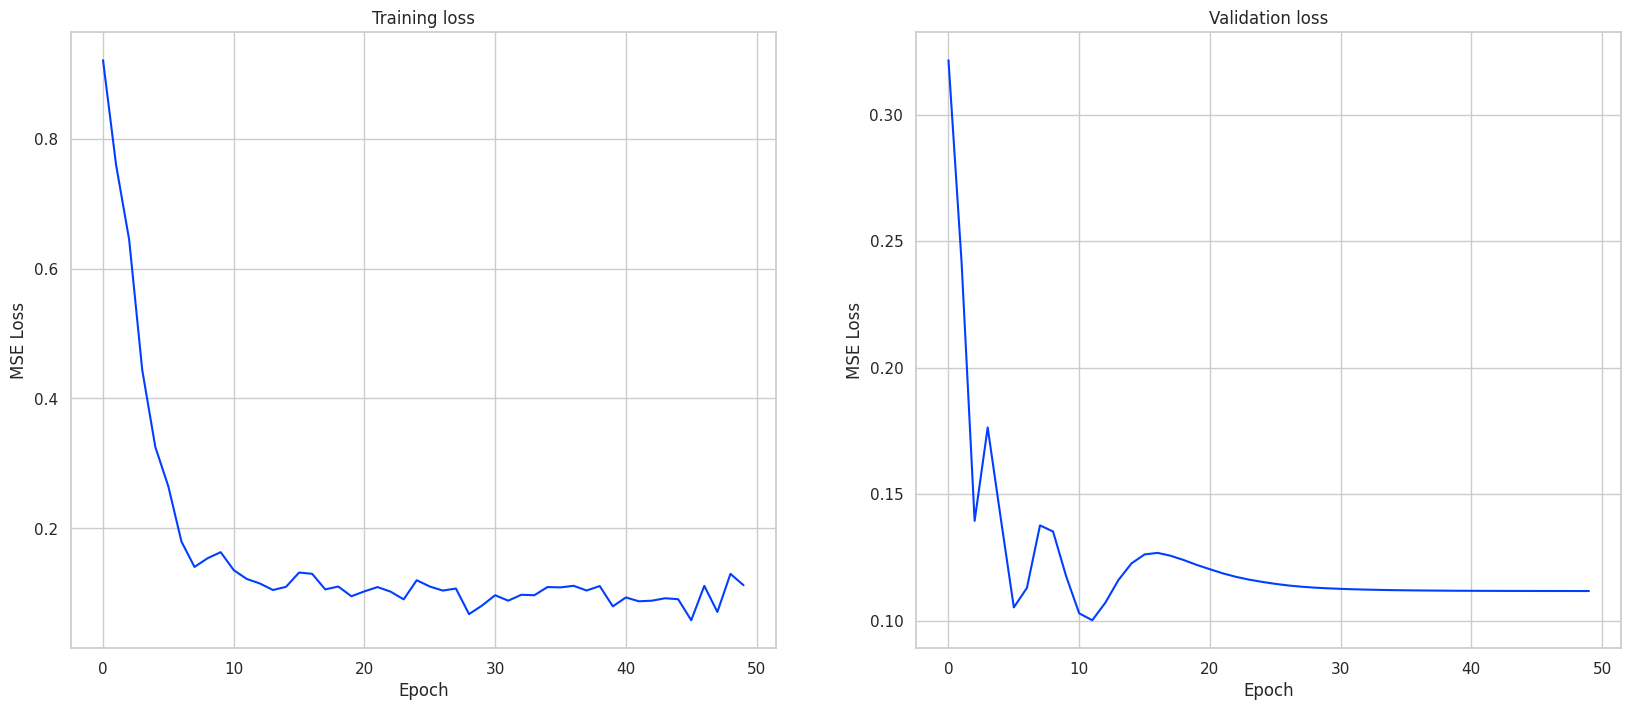

In [444]:
fig, ax=plt.subplots(1,2, figsize=(20,8))
# ax[0].plot(trainer.train_plot)
ax[0].plot(train_loss_plot)
ax[0].set_ylabel("MSE Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Training loss")

ax[1].plot(val_loss_plot)
ax[1].set_ylabel("MSE Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Validation loss")


### **Evaluate and Inference**

In [445]:
prediction,true_labels=test(test_loader)
prediction = prediction.reshape(-1)
true_labels = true_labels.reshape(-1)
prediction.shape, true_labels.shape
bert_embeddings_test_metrics = get_metrics(prediction,true_labels)
bert_embeddings_test_metrics

Train:   0%|          | 0/3 [00:00<?, ?it/s]

MSE      RMSE       MAE      MAPE  Serial Corr  Pearson Corr(IC),  \
0  71.641655  8.464139  5.783568  0.136616     0.347594           0.182844   

   Spearman Corr(IC)  
0           0.219204

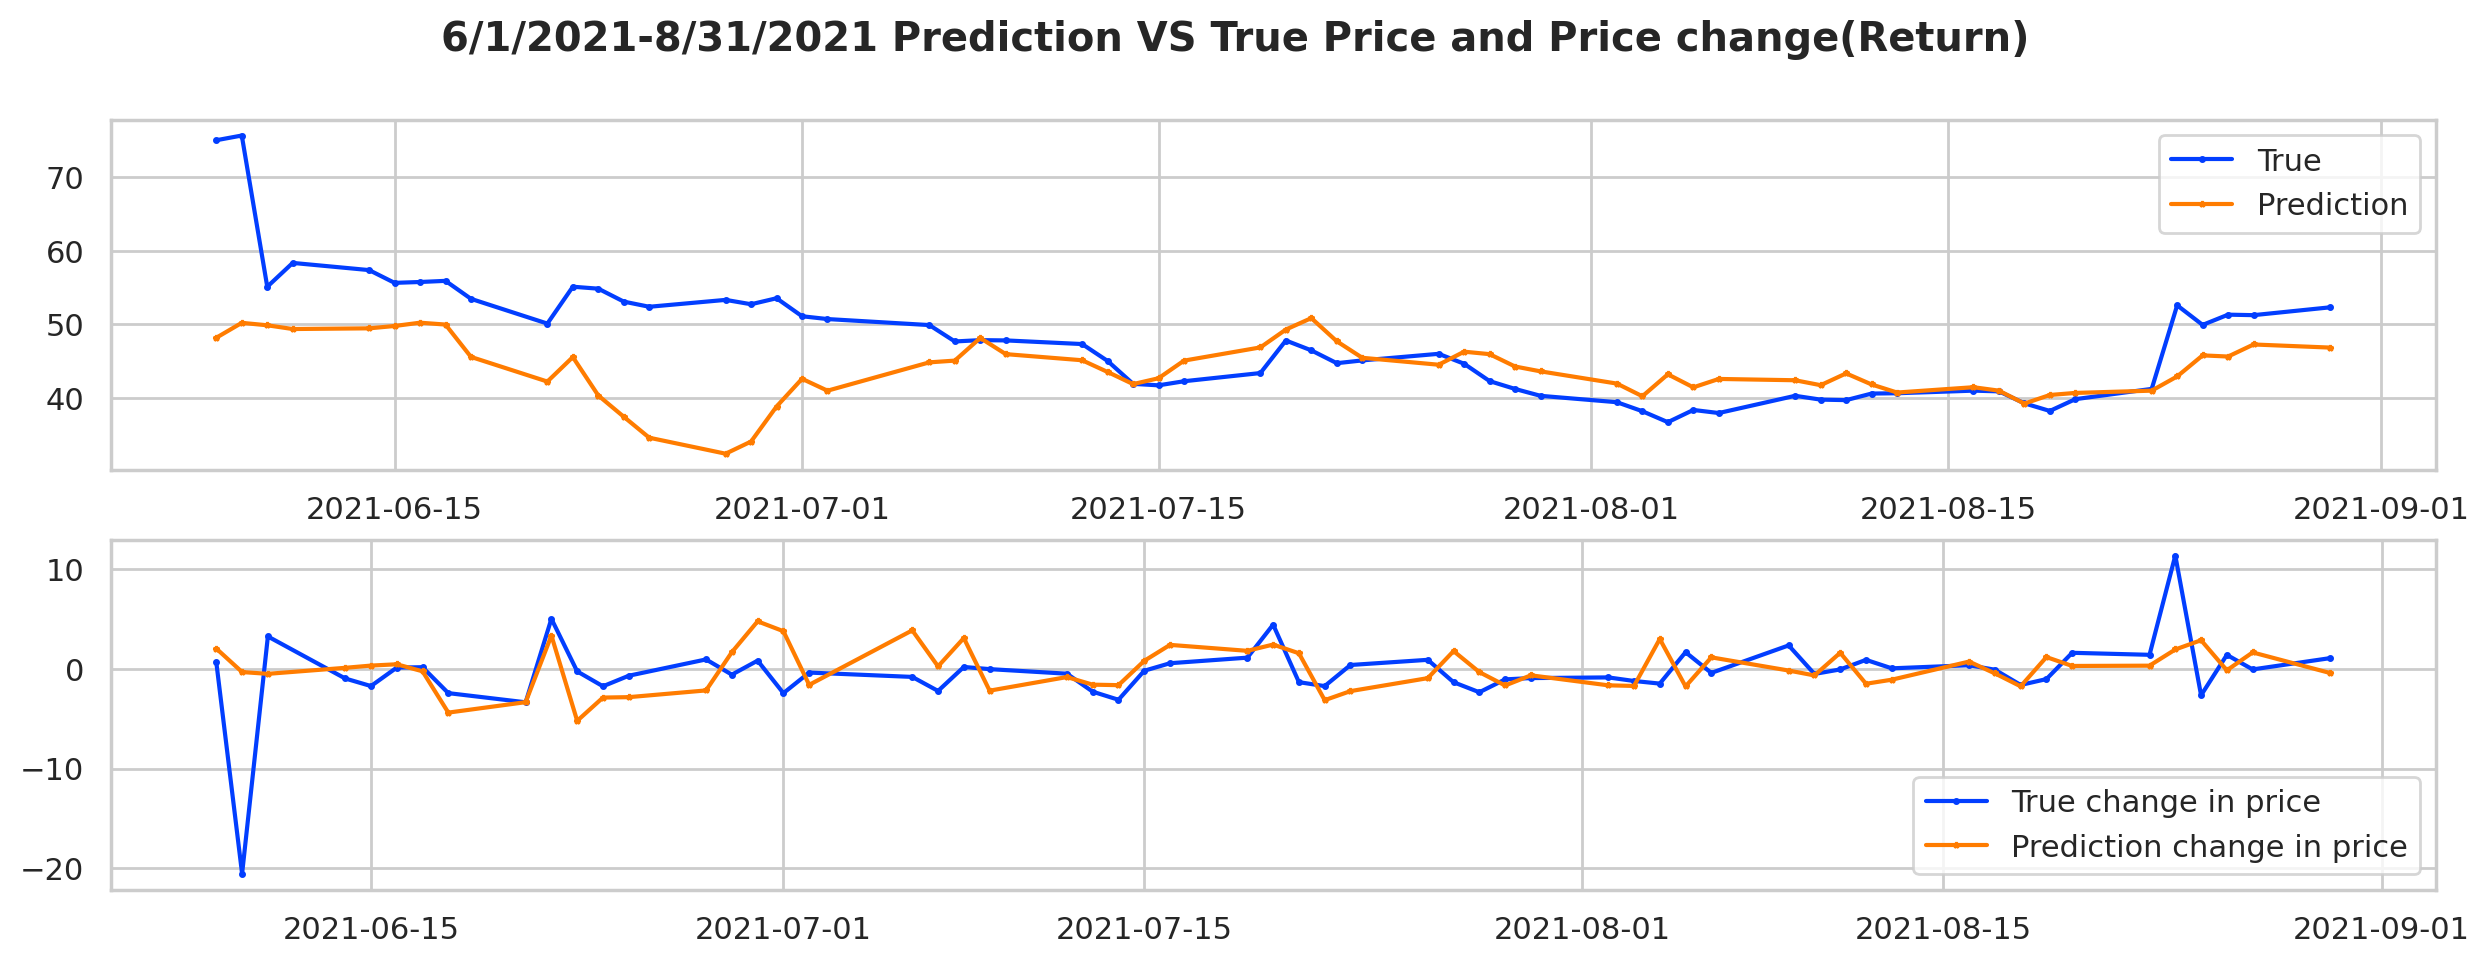

In [446]:
fig,ax=plt.subplots(2,1, figsize=(15,5),dpi=200)
date = df_ts[(df_ts.index>=pd.to_datetime("2021-06-08")) & (df_ts.index<=pd.to_datetime("2021-08-30"))].reset_index()['Date']
ax[0].plot(date, true_labels, label='True', marker='.', markersize=3)
ax[0].plot(date, prediction, label='Prediction',marker='*', markersize=2)
ax[0].legend()

ax[1].plot(date[1:], np.diff(true_labels), label='True change in price', marker='.', markersize=3)
ax[1].plot(date[1:],np.diff(prediction), label='Prediction change in price',marker='*', markersize=2)
ax[1].legend()
fig.suptitle("6/1/2021-8/31/2021 Prediction VS True Price and Price change(Return)", fontweight="bold")
plt.show()

In [447]:
df_inferencing = df_ts[df_ts.index<pd.to_datetime('2021-09-01')]
inference_indices = get_windows(df_inferencing, window_len, step_size=pred_len)

inference_data=TSDataset(torch.FloatTensor(np.array(df_inferencing.values)), inference_indices, window_len, pred_len=pred_len)

inference_loader = torch.utils.data.DataLoader(
    dataset     = inference_data,
    batch_size  = len(inference_data),
    pin_memory  = False,
    shuffle=False
)
# inference_indices

In [448]:
prediction,true_labels=test(inference_loader)
prediction = prediction.reshape(-1)
true_labels = true_labels.reshape(-1)
print(prediction.shape, true_labels.shape)
# print("Serial Correlation, True Correlation(IC)")
# print(np.corrcoef(prediction,true_labels)[0,1], np.corrcoef(np.diff(prediction),np.diff(true_labels))[0,1])
bert_embeddings_train_test_metrics = get_metrics(prediction,true_labels)
bert_embeddings_train_test_metrics

Train:   0%|          | 0/1 [00:00<?, ?it/s]

(149,) (149,)


MSE      RMSE       MAE     MAPE  Serial Corr  Pearson Corr(IC),  \
0  57.526085  7.584595  5.211614  0.14066     0.892676           0.598404   

   Spearman Corr(IC)  
0           0.286808

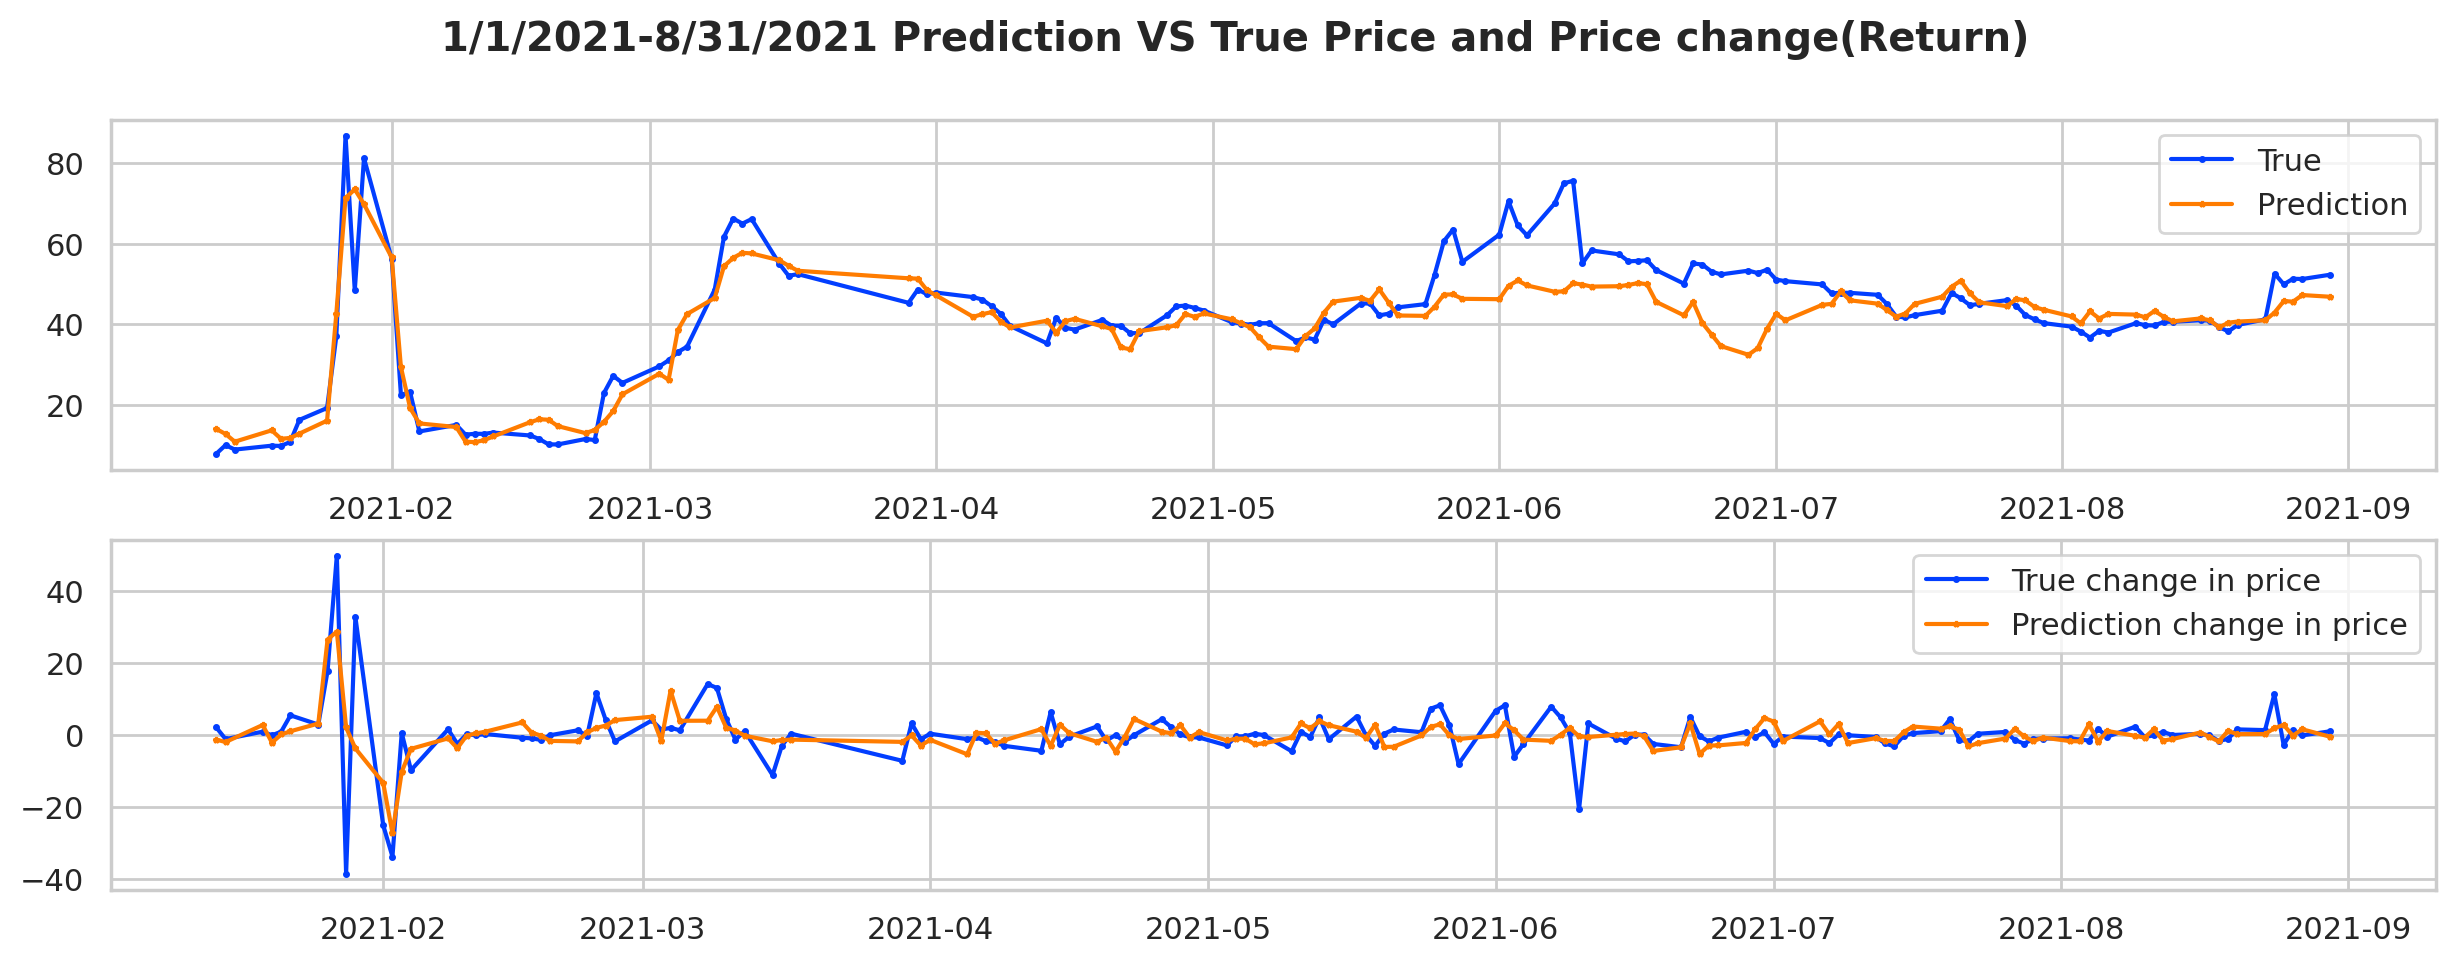

In [449]:
fig,ax=plt.subplots(2,1, figsize=(15,5),dpi=200)
date = df_ts[(df_ts.index>=pd.to_datetime("2021-01-13")) & (df_ts.index<=pd.to_datetime("2021-08-30"))].reset_index()['Date']
ax[0].plot(date,true_labels, label='True', marker='.', markersize=3)
ax[0].plot(date,prediction, label='Prediction',marker='*', markersize=2)
ax[0].legend()

ax[1].plot(date[1:],np.diff(true_labels), label='True change in price', marker='.', markersize=3)
ax[1].plot(date[1:], np.diff(prediction), label='Prediction change in price',marker='*', markersize=2)
ax[1].legend()
fig.suptitle("1/1/2021-8/31/2021 Prediction VS True Price and Price change(Return)", fontweight="bold")
plt.show()

# **Metrics**

In [450]:
df_metrics = pd.concat([baseline_test_metrics, tfidf_test_metrics, bert_embeddings_test_metrics])
df_metrics.index = ['Baseline_sentiment', 'TF-IDF', 'Bert_embeddings']
df_metrics

MSE       RMSE        MAE      MAPE  Serial Corr  \
Baseline_sentiment   74.499619   8.631316   6.192620  0.143273     0.869505   
TF-IDF              208.998901  14.456794  12.337156  0.355732     0.237816   
Bert_embeddings      71.641655   8.464139   5.783568  0.136616     0.347594   

                    Pearson Corr(IC),  Spearman Corr(IC)  
Baseline_sentiment          -0.202464          -0.094837  
TF-IDF                      -0.136563          -0.165280  
Bert_embeddings              0.182844           0.219204